In [ ]:
install.packages('gapminder')
install.packages('quantreg')
install.packages('margins')
library(tidyverse)
library(gapminder)
library(broom)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘SparseM’, ‘MatrixModels’, ‘conquer’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘prediction’


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Haciendo entendible una regresión
La visualización de datos es más que generar cifras que muestran los números sin procesar de una tabla de datos. Desde el principio, implica resumir o transformar partes de los datos y luego graficar los resultados. 

Los modelos estadísticos son una parte central de ese proceso. 

## Objetivos
- Entender brevemente cómo ggplot puede usar varias técnicas de modelado directamente dentro de geoms.
- Aprender a  usar las bibliotecas `broom` y `margins` para extraer y trazar de manera ordenada las estimaciones de los modelos que ajustamos

## Regresiones, geometrías y "smoothers"
Los histogramas, diagramas de densidad, boxplots y otras `geoms_` calculan números únicos o nuevas variables antes de trazarlos. Como vimos, estos cálculos se realizan mediante funciones `stat_`, cada una de las cuales trabaja mano a mano con su función `geom_` predeterminada, y viceversa. 

Además, a partir de las líneas de suavizado que dibujamos casi en los primeros gráficos que hicimos, hemos visto que las funciones `stat_` pueden realizar una buena cantidad de cálculos e incluso estimaciones de modelos sobre la marcha. La función `geom_smooth()` puede tomar una variedad de argumentos de método para ajustar LOESS, MCO, entre otros.

Tanto las funciones  `geom_smooth()` como `geom_quantile()` también pueden recibir instrucciones para usar fórmulas diferentes para producir sus ajustes.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



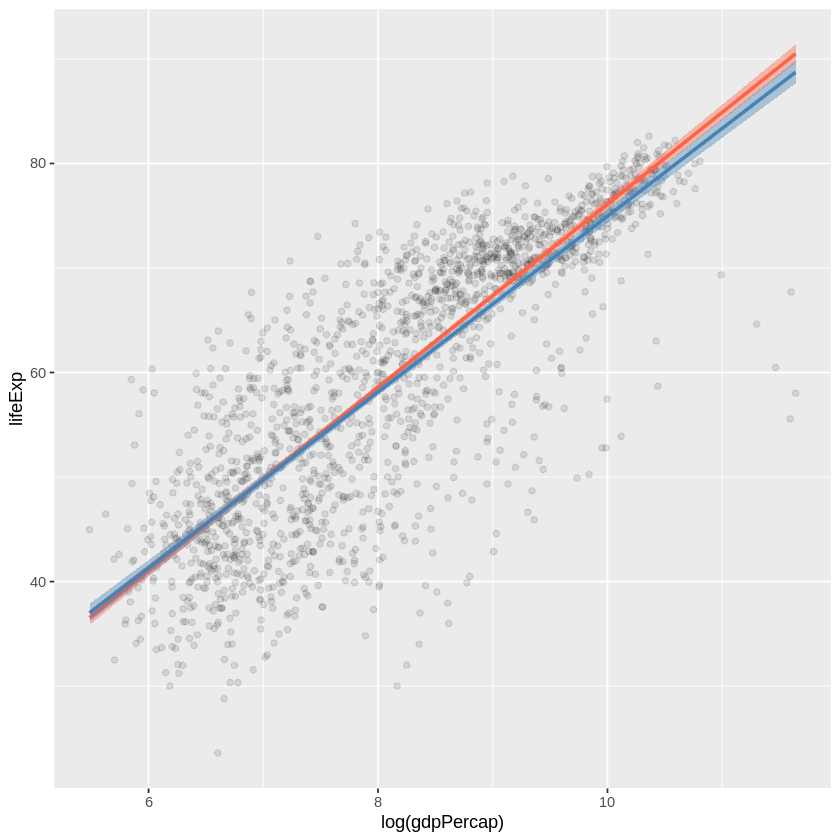

In [ ]:
p <- ggplot(data = gapminder,
            mapping = aes(x = log(gdpPercap), y = lifeExp))

p + geom_point(alpha=0.1) +
    geom_smooth(color = "tomato", fill="tomato", method = MASS::rlm) +
    geom_smooth(color = "steelblue", fill="steelblue", method = "lm")

En el plot superior, accedemos a la función `rlm` de la biblioteca `MASS` para ajustar una línea de regresión robusta.

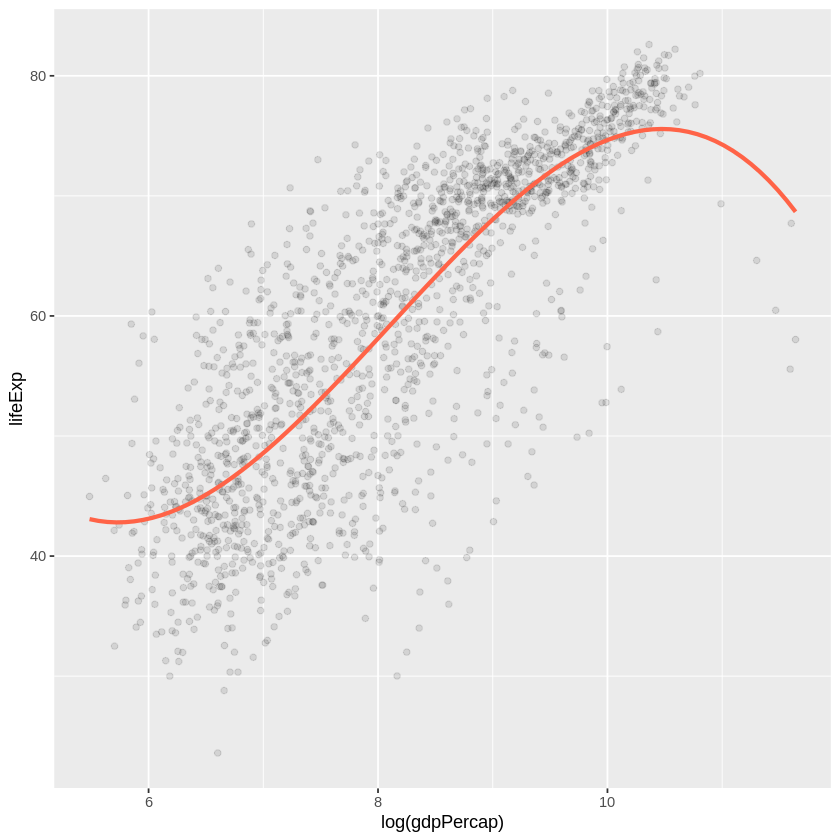

In [ ]:
p + geom_point(alpha=0.1) +
    geom_smooth(color = "tomato", method = "lm", size = 1.2, 
                formula = y ~ splines::bs(x, 3), se = FALSE)

En el segundo panel, la función `bs` se invoca directamente desde la biblioteca de `splines` de la misma manera, para ajustar una curva polinominal a los datos. 

Este es el mismo enfoque para acceder directamente a las funciones sin cargar una biblioteca completa que ya hemos usado varias veces cuando usamos funciones de la biblioteca de escalas. 

Smoothing formula not specified. Using: y ~ qss(x, lambda = 1)

Warning message in rq.fit.sfn(x, y, tau = tau, rhs = rhs, control = control, ...):
“tiny diagonals replaced with Inf when calling blkfct
”


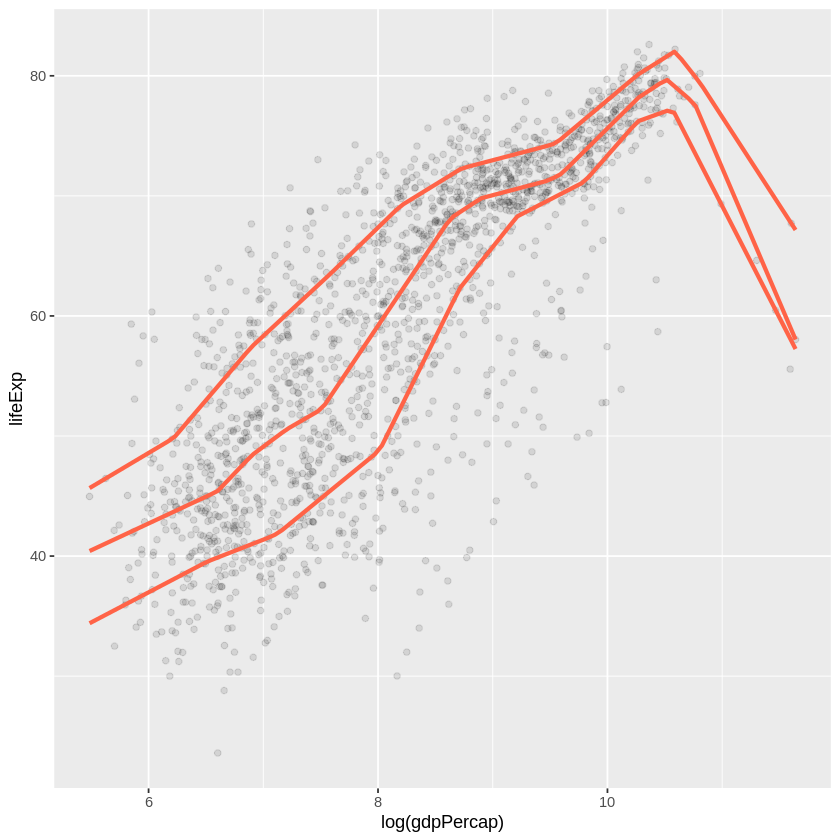

In [ ]:
p + geom_point(alpha=0.1) +
    geom_quantile(color = "tomato", size = 1.2, method = "rqss",
                  lambda = 1, quantiles = c(0.20, 0.5, 0.85))





Mientras tanto, la función `geom_quantile()` es como una versión especializada de `geom_smooth()` que puede ajustarse a líneas de regresión de cuantiles utilizando una variedad de métodos. 

El argumento `quantiles` toma un vector que especifica los cuantiles en los que se ajustan las líneas.

### Mostrando ajustes diferentes en un solo golpe
Como acabamos de ver en el primer plot, donde graficamos tanto un MCO como una línea de regresión robusta, podemos observar varios ajustes a la vez en el mismo gráfico colocando capas sobre nuevos suavizadores con `geom_smooth()`.

Siempre que establezcamos el color y la estética del `fill` en diferentes valores para cada ajuste, podemos distinguirlos visualmente fácilmente. Sin embargo, `ggplot` no dibujará una leyenda que nos oriente sobre qué ajuste es cuál. Esto se debe a que los suavizadores no están conectados lógicamente entre sí. Existen como capas separadas. ¿Qué pasa si comparamos varios ajustes diferentes y queremos una leyenda que los describa?

Resulta que `geom_smooth()` puede hacer esto a través de un camino raro: 

1. mapear el `color` y el `fill` a una cadena de text que describe el modelo que estamos ajustando, y 
2. luego usar `scale_color_manual()` y `scale_fill_manual()` para crear la leyenda. 

Primero usamos` brewer.pal ()` de la biblioteca `RColorBrewer` para extraer tres colores cualitativamente diferentes de una paleta más grande. Los colores se representan como valores hexadecimales. Como antes, usamos `::` para usar la función sin cargar toda la biblioteca: 

In [ ]:
model_colors <- RColorBrewer::brewer.pal(3, "Set1")
model_colors

[1] "#E41A1C" "#377EB8" "#4DAF4A"

Luego creamos un gráfico con tres smoothers diferentes, mapeando `color` y `fill` dentro de la función `aes()` como el nombre del smoother:


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



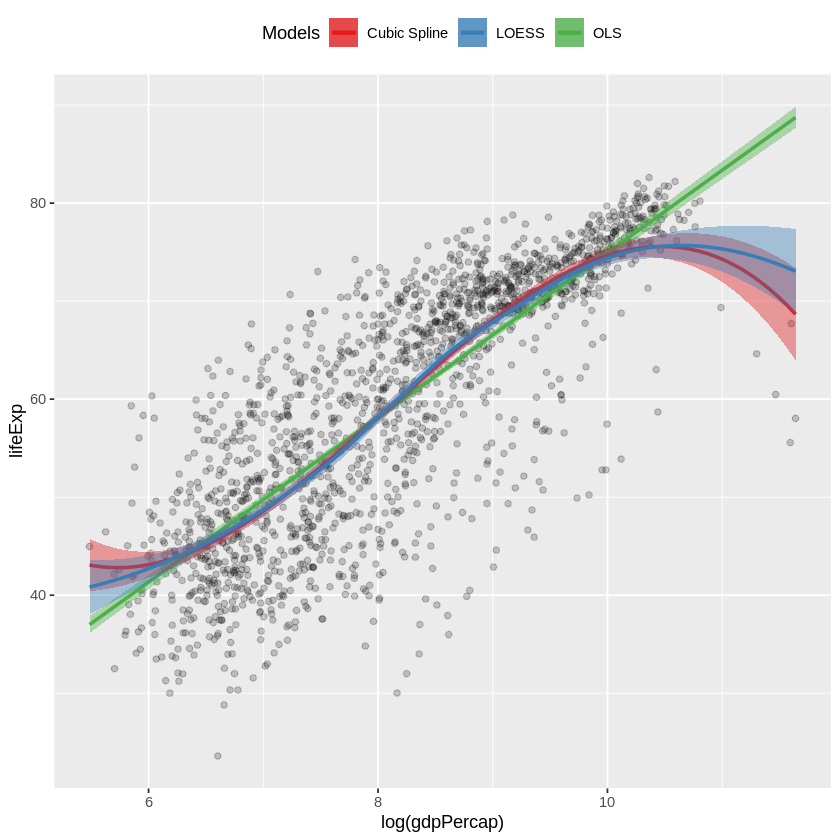

In [ ]:
p0 <- ggplot(data = gapminder,
            mapping = aes(x = log(gdpPercap), y = lifeExp))

p1 <- p0 + geom_point(alpha = 0.2) +
    geom_smooth(method = "lm", aes(color = "OLS", fill = "OLS")) +
    geom_smooth(method = "lm", formula = y ~ splines::bs(x, df = 3),
                aes(color = "Cubic Spline", 
                fill = "Cubic Spline")) +
    geom_smooth(method = "loess",
                aes(color = "LOESS", 
                fill = "LOESS"))


p1 + scale_color_manual(name = "Models", values = model_colors) +
    scale_fill_manual(name = "Models", values = model_colors) +
    theme(legend.position = "top")

De alguna manera le metimos un poco gato por liebre a `ggplot` aquí para que funcione. 

Hasta ahora, siempre hemos mapeado las `aes()` a los nombres de las variables, no a strings como “OLS” o “Cubic Splines”. De hecho, la clase pasada vimos que pasaban cosas extrañas cuando hacíamos eso. 

Aquí aprovechamos ese comportamiento, creando una nueva variable de valor único para el nombre de cada uno de nuestros modelos. `ggplot` construirá correctamente la leyenda si llamamos `scale_color_manual()` y `scale_fill_manual()`. Recuerden que tenemos que llamar a dos funciones de escala porque tenemos dos mapeos. El resultado es una única leyenda que contiene no solo nuestros tres suavizadores, sino también una leyenda apropiada para guiar al lector.

Estas características de ajuste de modelos hacen que `ggplot` sea muy útil para el trabajo exploratorio y facilitan la generación y comparación de tendencias basadas en modelos y otros resúmenes como parte del proceso de visualización de datos descriptivos. Las diversas funciones `stat_` son una forma flexible de agregar estimaciones resumidas de varios tipos a los gráficos. 

Pero también queremos más que esto, incluida la presentación de resultados de modelos que nos ajustamos a nosotros mismos.


### Mirando adentro de los objetos

Cubrir los detalles del ajuste de modelos estadísticos en R está más allá del alcance de este curso. Aquí discutiremos algunas formas de tomar los modelos que estimamos y extraer información con la que es fácil trabajar en `ggplot`. Nuestro objetivo, como siempre, es pasar de la forma en que el objeto está almacenado a una tabla tidy de números que podamos plotear. 

La mayoría de las clases de modelos estadísticos en R contendrán la información que necesitamos, o tendrán un conjunto especial de funciones o métodos diseñados para extraerla.

Podemos comenzar por aprender un poco más sobre cómo se almacena la salida de los modelos en R. Siempre estamos trabajando con objetos y los objetos tienen una estructura interna que consta de elementos con nombre. A veces, estos son números únicos, a veces vectores y, a veces, listas de cosas como vectores, matrices o fórmulas.

Hemos trabajado mucho con `tibbles` y `dataframes`. Estos almacenan tablas de datos con columnas con nombre, que quizás constan de diferentes clases de variables, como números enteros, caracteres, fechas o factores. Los objetos modelo vuelven a ser un poco más complicados.

In [ ]:
str(gapminder)

tibble [1,704 × 6] (S3: tbl_df/tbl/data.frame)
 $ country  : Factor w/ 142 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ continent: Factor w/ 5 levels "Africa","Americas",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ year     : int [1:1704] 1952 1957 1962 1967 1972 1977 1982 1987 1992 1997 ...
 $ lifeExp  : num [1:1704] 28.8 30.3 32 34 36.1 ...
 $ pop      : int [1:1704] 8425333 9240934 10267083 11537966 13079460 14880372 12881816 13867957 16317921 22227415 ...
 $ gdpPercap: num [1:1704] 779 821 853 836 740 ...


Siempre podemos usar `str()` para ver la estructura de los diferentes objetos con los que nos encontremos. Aquí hay mucha información sobre el objeto como un todo y cada variable que contiene. 

De la misma forma, los modelos estadísticos en R tienen una estructura interna. Pero debido a que los modelos son entidades más complejas que las tablas de datos, su estructura es generalmente más complicada. Hay más elementos y más tipos de información. Toda esta información generalmente se almacena o se puede calcular a partir de partes de un objeto modelo.

Podemos crear un modelo lineal, una regresión MCO, utilizando los datos de `gapminder`. 

Este conjunto de datos tiene una estructura país-año que hace que una especificación OLS como esta sea incorrecta. Pero eso no importa por ahora. Usamos la función `lm()` para ejecutar el modelo y lo almacenamos en un objeto llamado 


In [ ]:
out <- lm(formula = lifeExp ~ gdpPercap + pop + continent,
          data = gapminder)

El primer argumento es la fórmula del modelo. `lifeExp` es la variable dependiente y el operador `~` se usa para designar los lados izquierdo y derecho de un modelo (incluso en casos, como vimos con `facet_wrap()` donde el modelo solo tiene un lado derecho).

Veamos los resultados pidiéndole a R que imprima un resumen del modelo.

In [ ]:
summary(out)


Call:
lm(formula = lifeExp ~ gdpPercap + pop + continent, data = gapminder)

Residuals:
    Min      1Q  Median      3Q     Max 
-49.161  -4.486   0.297   5.110  25.175 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       4.781e+01  3.395e-01 140.819  < 2e-16 ***
gdpPercap         4.495e-04  2.346e-05  19.158  < 2e-16 ***
pop               6.570e-09  1.975e-09   3.326 0.000901 ***
continentAmericas 1.348e+01  6.000e-01  22.458  < 2e-16 ***
continentAsia     8.193e+00  5.712e-01  14.342  < 2e-16 ***
continentEurope   1.747e+01  6.246e-01  27.973  < 2e-16 ***
continentOceania  1.808e+01  1.782e+00  10.146  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.365 on 1697 degrees of freedom
Multiple R-squared:  0.5821,	Adjusted R-squared:  0.5806 
F-statistic: 393.9 on 6 and 1697 DF,  p-value: < 2.2e-16


Cuando usamos la función `summary()` en `out`, no obtenemos un conjunto de estadísticas de resumen simples. 

En este caso, lo que se imprime en la consola es en parte información que se almacena dentro del objeto del modelo y en parte información que la función `summary()` ha calculado y formateado para mostrarla en la pantalla. 

Detrás de escena, `summary()` obtiene ayuda de otras funciones. Los objetos de diferentes clases tienen métodos predeterminados asociados con ellos, de modo que cuando la función de `summary()` genérica se aplica a un objeto de modelo lineal, la función sabe que debe pasar el trabajo a una función más especializada que hace un montón de cálculos y formatea adecuadamente a un objeto de modelo lineal. 

Usamos la misma función `summary()` genérica en los dataframes: `summary(gapminder)`. Para nosotros, lo que escribimos es lo mismo, pero en cada caso se aplica un método predeterminado diferente.

`summary()` proporciona un resumen del modelo, pero realmente no podemos hacer ningún análisis adicional con él directamente. Por ejemplo, ¿qué pasa si queremos plotear alguna información del modelo? La información necesaria para hacer gráficos está dentro del objeto, pero no es obvio cómo usarlo.

In [ ]:
str(out)

List of 13
 $ coefficients : Named num [1:7] 4.78e+01 4.50e-04 6.57e-09 1.35e+01 8.19 ...
  ..- attr(*, "names")= chr [1:7] "(Intercept)" "gdpPercap" "pop" "continentAmericas" ...
 $ residuals    : Named num [1:1704] -27.6 -26.1 -24.5 -22.4 -20.3 ...
  ..- attr(*, "names")= chr [1:1704] "1" "2" "3" "4" ...
 $ effects      : Named num [1:1704] -2455.1 311.1 42.6 101.1 -17.2 ...
  ..- attr(*, "names")= chr [1:1704] "(Intercept)" "gdpPercap" "pop" "continentAmericas" ...
 $ rank         : int 7
 $ fitted.values: Named num [1:1704] 56.4 56.4 56.5 56.5 56.4 ...
  ..- attr(*, "names")= chr [1:1704] "1" "2" "3" "4" ...
 $ assign       : int [1:7] 0 1 2 3 3 3 3
 $ qr           :List of 5
  ..$ qr   : num [1:1704, 1:7] -41.2795 0.0242 0.0242 0.0242 0.0242 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:1704] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:7] "(Intercept)" "gdpPercap" "pop" "continentAmericas" ...
  .. ..- attr(*, "assign")= int [1:7] 0 1 2 3 3 3 3
  .. ..- attr(*, "con

Si echamos un vistazo a la estructura del objeto modelo con `str(out)`, vemos que es un despiole.  La mayoría de los objetos coplejos en R (como los outputs de un modelo) `out` está organizado como una lista con diferentes elementos. 

Varios de estos elementos son en sí mismos listas. La figura siguiente ofrece un esquema una vista esquemática del contenido de un objeto de modelo lineal. 

<img src="https://socviz.co/assets/ch-06-lm-object-schematic.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;"/>

En esta lista hay vectores, dataframes, strings e incluso otras listas. Algunos son datos que le pasamos nosotros, otros son datos calculados por el modelo lineal.

Los objetos podrían considerarse organizados como un sistema de archivo: los gabinetes contienen cajones y el cajón puede contener páginas de información, documentos completos o grupos de carpetas con más documentos en su interior.

Podemos acceder a los elementos a través del nombre (y usando la sintaxis de R-base)


In [ ]:
out$coefficients

(Intercept)         gdpPercap               pop continentAmericas 
     4.781408e+01      4.495058e-04      6.569823e-09      1.347594e+01 
    continentAsia   continentEurope  continentOceania 
     8.192632e+00      1.747269e+01      1.808330e+01


El resultado `summary()` se presenta de una manera compacta y eficiente en términos de transmitir información, pero también "no tidyficada".

Hay una tabla de coeficientes, pero los nombres de las variables están en las filas. Los nombres de las columnas son incómodos y parte de la información (por ejemplo, en la parte inferior de la salida) se ha calculado e impreso, pero no se almacena en el objeto del modelo.

## Presentando los modelos de forma correcta
Las cifras basadas en modelos estadísticos enfrentan todos los desafíos ordinarios de la visualización de datos efectiva, y más. Esto se debe a que los resultados del modelo suelen conllevar una considerable carga adicional de interpretación y conocimientos básicos necesarios. 

Cuanto más complejo es el modelo, más complicado se vuelve transmitir esta información de manera eficaz y más fácil es llevar al público o a uno mismo al error.

Graficar un modelo está indisolublemente ligado a la estimación del propio modelo: un gráfico, por más bonito que sea, no es un sustituto de la comprensión del modelo en sí.

### Algunas buenas prácticas 

Veamos algunas ideas generales sobre los buenos gráficos basados ​​en modelos y trabajar con algunos ejemplos de cómo `ggplot` y algunas bibliotecas adicionales pueden facilitar la obtención de buenos resultados.


1. Presentar los resultados en términos sustantivos 
Los gráficos útiles basados ​​en modelos muestran los resultados de manera sustancialmente significativa y directamente interpretable con respecto a las preguntas que el análisis está tratando de responder. Esto significa mostrar resultados en un contexto en el que otras variables del análisis se mantienen en valores sensibles, como sus medias o medianas. Con variables continuas, a menudo puede ser útil generar valores pronosticados que cubran algún movimiento sustancialmente significativo a través de la distribución, como del percentil 25 al 75, en lugar de un incremento de una sola unidad en la variable de interés. Para las variables categóricas no ordenadas, los valores predichos pueden presentarse con respecto a la categoría modal en los datos, o para una categoría particular de interés teórico. Presentar hallazgos sustancialmente interpretables a menudo también significa usar (y a veces convertir a) una escala que los lectores puedan comprender fácilmente. Si los informes de su modelo dan como resultado log-odds, por ejemplo, convertir las estimaciones en probabilidades predichas facilitará la interpretación. Todos estos consejos son bastante generales. Cada uno de estos puntos se aplica igualmente bien a la presentación de los resultados resumidos en una tabla que en un gráfico. No hay nada distintivamente gráfico en centrarse en el significado sustantivo de sus hallazgos.

2. "Blanquear" los niveles de confianza. Lo mismo se aplica a la presentación del grado de incertidumbre o confianza que tiene en sus resultados. Las estimaciones del modelo vienen con varias medidas de precisión, confianza, credibilidad o importancia. Presentar e interpretar estas medidas es notoriamente propenso a malas interpretaciones o sobreinterpretaciones, ya que tanto los investigadores como el público exigen más de cosas como los intervalos de confianza y los valores p de lo que estas estadísticas pueden ofrecer. Como mínimo, después de haber decidido una medida adecuada de ajuste del modelo o la evaluación correcta de la confianza, debe mostrar su rango cuando presente sus resultados. Una familia de geoms ggplot relacionadas le permite mostrar un rango o intervalo definido por posición en el eje xy luego un rango ymin e ymax en el eje y. Estos geoms incluyen geom_pointrange () y geom_errorbar (), que veremos en acción en breve. Un geom relacionado, geom_ribbon () usa los mismos argumentos para dibujar áreas rellenas y es útil para trazar rangos de valores del eje y a lo largo de algunos ejes x que varían continuamente.

3. (Si es posible) mostrar los datos. Trazar los resultados de un modelo multivariado generalmente significa una de dos cosas. Primero, podemos mostrar lo que es en efecto una tabla de coeficientes con medidas de confianza asociadas, quizás organizando los coeficientes en grupos significativos, o por el tamaño de la asociación predicha, o ambos. En segundo lugar, podemos mostrar los valores predichos de algunas variables (en lugar de solo los coeficientes de un modelo) en algún rango de interés. El último enfoque nos permite mostrar los puntos de datos originales si lo deseamos. La forma en que ggplot crea gráficos capa por capa nos permite combinar fácilmente las estimaciones del modelo (por ejemplo, una línea de regresión y un rango asociado) y los datos subyacentes. En efecto, estas son versiones construidas manualmente de los gráficos generados automáticamente que hemos estado produciendo con geom_smooth () desde el comienzo de este libro.

## Generar predicciones para graficar
Entonces, habiendo ajustado un modelo, es posible que deseemos obtener un gráfico de las estimaciones que produce en el rango de alguna variable en particular, manteniendo constantes otras covariables en algunos valores sensibles. 

La función `predict()` es una forma genérica de utilizar objetos de modelo para producir este tipo de predicción. En R, las funciones "genéricas" toman sus entradas y las pasan a funciones más específicas detrás de escena, aquellas que son adecuadas para trabajar con el tipo particular de objeto modelo que tenemos. 

Los detalles de obtener valores predichos de un modelo MCO, por ejemplo, serán algo diferentes de obtener predicciones de una regresión logística. Pero en cada caso podemos usar la misma `predict()`, teniendo cuidado de verificar la documentación para ver en qué forma se devuelven los resultados para el tipo de modelo con el que estamos trabajando. Muchas de las funciones más utilizadas en R son genéricas de esta manera. `summary()`, por ejemplo, trabaja en objetos de muchas clases diferentes, desde vectores hasta marcos de datos y modelos estadísticos, produciendo una salida apropiada en cada caso por medio de una función específica de clase en segundo plano.

Para que `predict()` calcule los nuevos valores por nosotros, necesita algunos datos nuevos para ajustar el modelo. Generaremos un nuevo `data.frame` cuyas columnas tienen los mismos nombres que las variables en los datos originales del modelo, pero donde las filas tienen nuevos valores. 

Una función muy útil llamada `expand.grid()` nos ayudará a hacer esto. Le daremos una lista de variables, especificando el rango de valores que queremos que tome cada variable. Luego `expand.grid()` generará el multiplicará el rango completo de valores para todas las combinaciones de los valores que le damos, creando así un `data.frame` de datos con los nuevos datos que necesitamos.

En el siguiente fragmento de código, usamos `min()` y `max()` para obtener los valores mínimo y máximo del PIB per cápita, y luego creamos un vector con cien elementos espaciados uniformemente entre el mínimo y el máximo. Mantenemos la población constante en su mediana y dejamos que continente tome los cinco valores disponibles.

In [ ]:
min_gdp <- min(gapminder$gdpPercap)
max_gdp <- max(gapminder$gdpPercap)
med_pop <- median(gapminder$pop)

pred_df <- expand.grid(gdpPercap = (seq(from = min_gdp,
                                        to = max_gdp,
                                        length.out = 100)),
                       pop = med_pop,
                       continent = c("Africa", "Americas",
                                     "Asia", "Europe", "Oceania"))

In [ ]:
dim(pred_df)
head(pred_df)

[1] 500   3

,gdpPercap,pop,continent
,<dbl>,<dbl>,<fct>
1,241.1659,7023596,Africa
2,1385.4282,7023596,Africa
3,2529.6905,7023596,Africa
4,3673.9528,7023596,Africa
5,4818.2150,7023596,Africa
6,5962.4773,7023596,Africa


Ahora podemos usar `predict()`. Si le pasamos nuestros nuevos datos y el modelo, sin ningún otro argumento, va a calcular los valores predichos para cada fila en el `data.frame`. 

Si especificamos `intervalo = 'predict'` como argumento, calculará intervalos de predicción del 95% además de la estimación puntual.

In [ ]:
pred_out <- predict(object = out,
                    newdata = pred_df,
                    interval = "predict")
head(pred_out)

,fit,lwr,upr
1,47.96863,31.54775,64.38951
2,48.48298,32.06231,64.90365
3,48.99733,32.57670,65.41797
4,49.51169,33.09092,65.93245
5,50.02604,33.60497,66.44711
6,50.54039,34.11885,66.96193


Como sabemos que, por diseño, los casos en `pred_df` y `pred_out` corresponden fila por fila, podemos unir los dos `data.frame` por columna. Este método de unir o fusionar tablas definitivamente no se recomienda cuando se trata de datos.

In [ ]:
pred_df <- cbind(pred_df, pred_out)
head(pred_df)

,gdpPercap,pop,continent,fit,lwr,upr
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,241.1659,7023596,Africa,47.96863,31.54775,64.38951
2,1385.4282,7023596,Africa,48.48298,32.06231,64.90365
3,2529.6905,7023596,Africa,48.99733,32.57670,65.41797
4,3673.9528,7023596,Africa,49.51169,33.09092,65.93245
5,4818.2150,7023596,Africa,50.02604,33.60497,66.44711
6,5962.4773,7023596,Africa,50.54039,34.11885,66.96193


El resultado final es un `data.frame` ordenado, que contiene los valores predichos del modelo para el rango de valores que especificamos. 

Ahora podemos graficar los resultados. Debido a que producimos una gama completa de valores predichos, podemos decidir si usarlos o no todos. Aquí subseteamos solo para Europa y África.

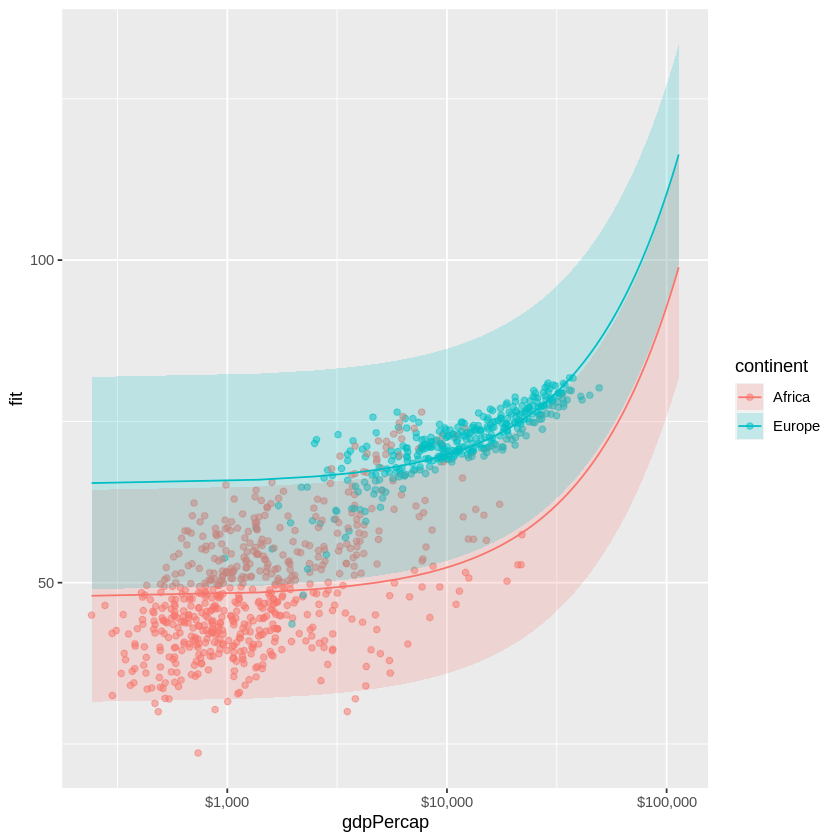

In [ ]:
p <- ggplot(data = subset(pred_df, continent %in% c("Europe", "Africa")),
            aes(x = gdpPercap,
                y = fit, 
                ymin = lwr, 
                ymax = upr,
                color = continent,
                fill = continent,
                group = continent))

p + geom_point(data = subset(gapminder,
                             continent %in% c("Europe", "Africa")),
               aes(x = gdpPercap, y = lifeExp,
                   color = continent),
               alpha = 0.5,
               inherit.aes = FALSE) + 
    geom_line() +
    geom_ribbon(alpha = 0.2, color = FALSE) +
    scale_x_log10(labels = scales::dollar)

Usamos una nueva `geom` aquí para dibujar el área cubierta por los intervalos de predicción: `geom_ribbon()`. Toma un argumento `x` como una línea, pero un argumento `ymin` e `ymax` como se especifica en el mapeo estético `ggplot()`. Esto define los límites superior e inferior del intervalo de predicción.

En la práctica, es posible que no utilicemos `predict()` directamente con tanta frecuencia. En su lugar, podemos escribir código utilizando bibliotecas adicionales que encapsulan el proceso de producir predicciones y diagramas a partir de modelos. 

Estos son especialmente útiles cuando su modelo es un poco más complejo y la interpretación de los coeficientes se vuelve más complicada. Esto sucede, por ejemplo, cuando tiene una variable de resultado binaria y necesita convertir los resultados de una regresión logística en probabilidades predichas, o cuando tiene términos de interacción entre sus predicciones. Discutiremos algunas de estas bibliotecas auxiliares en las próximas secciones. Sin embargo, `predict()` y su capacidad para trabajar de forma segura con diferentes clases de modelos sustenta muchas de esas bibliotecas. Por lo tanto, es útil verlo en acción de primera mano para comprender lo que está haciendo..

---
### Actividad
Generar el mismo gráfico pero para América Latina y Asia

In [ ]:
####

---

## Ordenando modelos con `broom`
La función `tidy()` toma un objeto modelo y devuelve un `data.frame` de información a nivel de componente. Podemos trabajar con esto para hacer gráficos de una manera familiar, y mucho más fácilmente que pescar dentro del objeto modelo para extraer los distintos términos. 

A continuación, se muestra un ejemplo que utiliza los resultados predeterminados que se acaban de devolver. Para una visualización más conveniente de los resultados, canalizaremos el objeto que creamos con `tidy()` a través de una función que redondea las columnas numéricas del marco de datos a dos lugares decimales. Por supuesto, esto no cambia nada sobre el objeto en sí.

In [ ]:
out_comp <- tidy(out)
out_comp %>% mutate(across(-term, round, digits=2))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),47.81,0.34,140.82,0
gdpPercap,0.00,0.00,19.16,0
pop,0.00,0.00,3.33,0
continentAmericas,13.48,0.60,22.46,0
continentAsia,8.19,0.57,14.34,0
continentEurope,17.47,0.62,27.97,0
continentOceania,18.08,1.78,10.15,0


Ahora podemos tratar este `data.frame` como cualquier otro dataset que hayamos visto hasta ahora.

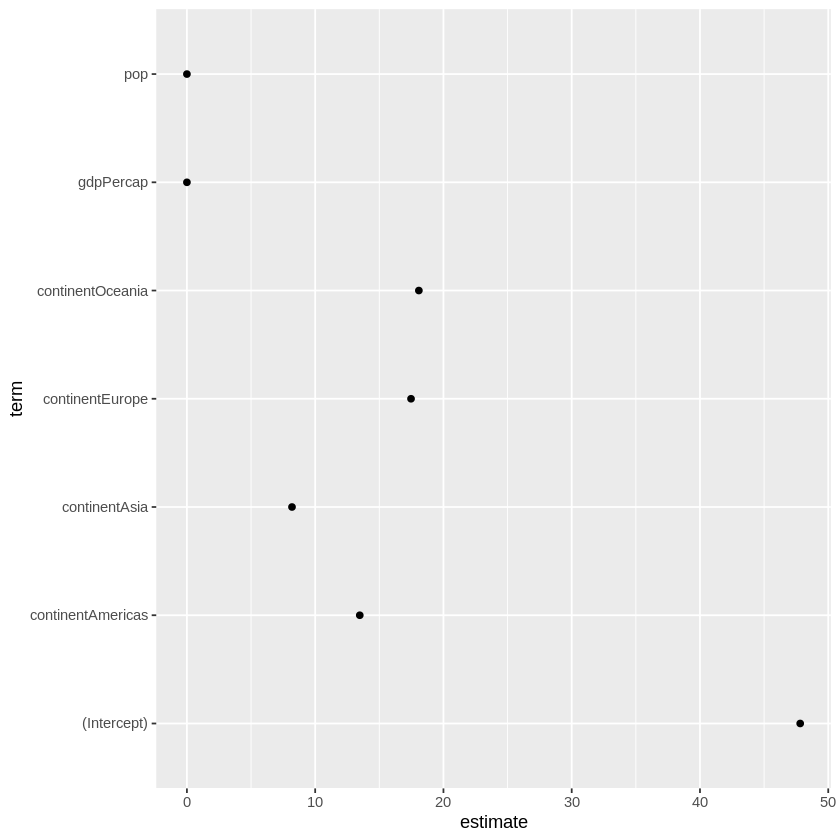

In [ ]:
p <- ggplot(out_comp, mapping = aes(x = term,
                                    y = estimate))

p + geom_point() + coord_flip() 

Podemos ampliar y limpiar esta parcela de varias formas. Por ejemplo, podemos decirle a `tidy()` que calcule los intervalos de confianza para las estimaciones, utilizando la función `confint()` de R.


In [ ]:
out_conf <- tidy(out, conf.int = TRUE)
out_conf %>% mutate(across(-term, round, digits=2))

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),47.81,0.34,140.82,0,47.15,48.48
gdpPercap,0.00,0.00,19.16,0,0.00,0.00
pop,0.00,0.00,3.33,0,0.00,0.00
continentAmericas,13.48,0.60,22.46,0,12.30,14.65
continentAsia,8.19,0.57,14.34,0,7.07,9.31
continentEurope,17.47,0.62,27.97,0,16.25,18.70
continentOceania,18.08,1.78,10.15,0,14.59,21.58


Vamos a quitar el término de `intercept` de la tabla. 

También queremos formatear de forma bonita las etiquetas.

Al ajustar un modelo con variables categóricas, R creará nombres de coeficientes basados ​​en el nombre de la variable y el nombre de la categoría, como `continentAméricas`. Normalmente nos gusta limpiarlos antes de plotear.

Por lo general, solo queremos eliminar el nombre de la variable al comienzo de la etiqueta del coeficiente. 



Para esto podemos usar prefix_strip (), una función de conveniencia en la biblioteca socviz. Le decimos qué prefijos eliminar, usándolo para crear una nueva variable de columna en out_conf que corresponde a la columna de términos, pero que tiene etiquetas más bonitas.

In [ ]:
out_conf <- subset(out_conf, !term %in% "(Intercept)")
out_conf <- out_conf %>% mutate(term = str_remove(term, 'continent'))
out_conf

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gdpPercap,4.495058e-04,2.346323e-05,19.157877,3.238989e-74,4.034858e-04,4.955257e-04
pop,6.569823e-09,1.975450e-09,3.325735,9.006691e-04,2.695249e-09,1.044440e-08
Americas,1.347594e+01,6.000420e-01,22.458335,5.188082e-98,1.229904e+01,1.465284e+01
Asia,8.192632e+00,5.712355e-01,14.341952,4.064264e-44,7.072232e+00,9.313032e+00
Europe,1.747269e+01,6.246165e-01,27.973474,6.335054e-142,1.624759e+01,1.869779e+01
Oceania,1.808330e+01,1.782254e+00,10.146310,1.589607e-23,1.458766e+01,2.157895e+01


Ahora podemos usar `geom_pointrange()` para hacer una figura que muestre algo de información sobre nuestra confianza en las estimaciones de las variables, en lugar de solo los coeficientes. 

Al igual que con las gráficas de caja anteriores, usamos `reorder()` para ordenar los nombres de los términos del modelo por la variable de estimación, ordenando así nuestra gráfica de efectos de mayor a menor magnitud.

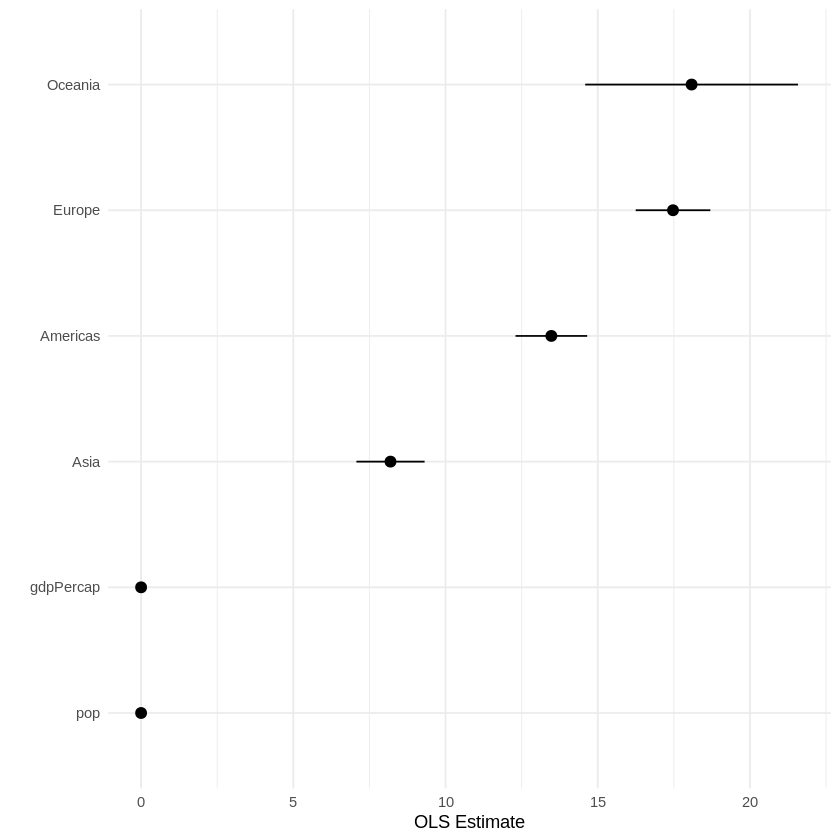

In [ ]:
p <- ggplot(out_conf, mapping = aes(x = reorder(term, estimate),
                                    y = estimate, 
                                    ymin = conf.low, 
                                    ymax = conf.high))

p + 
    geom_pointrange() + 
    coord_flip() + 
    labs(x="", y="OLS Estimate") +
    theme_minimal()

Los gráficos de puntos (dotplots) de este tipo pueden ser muy compactos. El eje vertical a menudo se puede comprimir bastante, sin pérdida de información. 

De hecho, a menudo son más fáciles de leer con mucho menos espacio entre las filas que el que ofrece una forma cuadrada predeterminada.

### Obtener estadísticas de nivel de observación con `augment()`

Los valores devueltos por `augment()` son estadísticos calculadas al nivel de las observaciones originales. Como tales, se pueden agregar al `data.frame` en el que se basa el modelo. Una llamada a `augment()` devolverá un `data.frame` con todas las observaciones originales utilizadas en la estimación del modelo, junto con una serie de colunmas como las siguientes:

- `.fitted`: los valores ajustados del modelo.
- `.se.fit`: los errores estándar de los valores ajustados.
- .`resid`: los residuos.
- `.hat`: la diagonal de la _hat matrix_
- `.sigma`: una estimación de la desviación estándar residual cuando la observación correspondiente se elimina del modelo.
- `.cooksd`: distancia de Cook, un diagnóstico de regresión común; y
- `.std`.resid: los residuos estandarizados.


Cada una de estas variables se nombra con un punto inicial, por ejemplo `.hat` en lugar de `hat`, y así sucesivamente. Esto es para evitar confundirlo accidentalmente con (o sobrescribir accidentalmente) una variable existente en sus datos con este nombre. Las columnas de valores devueltas diferirán ligeramente según la clase de modelo que se esté ajustando.

In [ ]:
out_aug <- augment(out)
head(out_aug) %>% mutate(across(-continent, round, digits=3))

lifeExp,gdpPercap,pop,continent,.fitted,.resid,.hat,.sigma,.cooksd,.std.resid
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28.801,779.445,8425333,Asia,56.412,-27.611,0.003,8.341,0.005,-3.306
30.332,820.853,9240934,Asia,56.436,-26.104,0.003,8.344,0.004,-3.126
31.997,853.101,10267083,Asia,56.458,-24.461,0.003,8.347,0.004,-2.929
34.020,836.197,11537966,Asia,56.458,-22.438,0.003,8.350,0.003,-2.687
36.088,739.981,13079460,Asia,56.425,-20.337,0.003,8.353,0.003,-2.435
38.438,786.113,14880372,Asia,56.458,-18.020,0.003,8.356,0.002,-2.158


Por defecto, `augment()` va a extraer la data disponibles del objeto modelo. Por lo general, esto incluirá las variables utilizadas en el modelo en sí, pero no las adicionales contenidas en el `data.frame` original. A veces es útil tener estos. Podemos agregarlos especificando el argumento de datos:

In [ ]:
out_aug <- augment(out, data = gapminder)
head(out_aug) %>% mutate(across(-c(country, continent), round, digits=3))

country,continent,year,lifeExp,pop,gdpPercap,.fitted,.resid,.hat,.sigma,.cooksd,.std.resid
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,Asia,1952,28.801,8425333,779.445,56.412,-27.611,0.003,8.341,0.005,-3.306
Afghanistan,Asia,1957,30.332,9240934,820.853,56.436,-26.104,0.003,8.344,0.004,-3.126
Afghanistan,Asia,1962,31.997,10267083,853.101,56.458,-24.461,0.003,8.347,0.004,-2.929
Afghanistan,Asia,1967,34.020,11537966,836.197,56.458,-22.438,0.003,8.350,0.003,-2.687
Afghanistan,Asia,1972,36.088,13079460,739.981,56.425,-20.337,0.003,8.353,0.003,-2.435
Afghanistan,Asia,1977,38.438,14880372,786.113,56.458,-18.020,0.003,8.356,0.002,-2.158


Si algunas filas que contienen datos faltantes se descartaron para ajustarse al modelo, estas no se trasladarán al `data.frame`  aumentado.

Las nuevas columnas creadas por `augment()` se pueden usar para crear algunos gráficos de regresión estándar. Por ejemplo, podemos graficar los [residuos frente a los valores ajustados](https://https://online.stat.psu.edu/stat501/lesson/4/4.2). La siguiente figura sugiere, como era de esperar, que los datos de nuestro país-año tienen una estructura bastante mayor que la que captura nuestro modelo MCO.

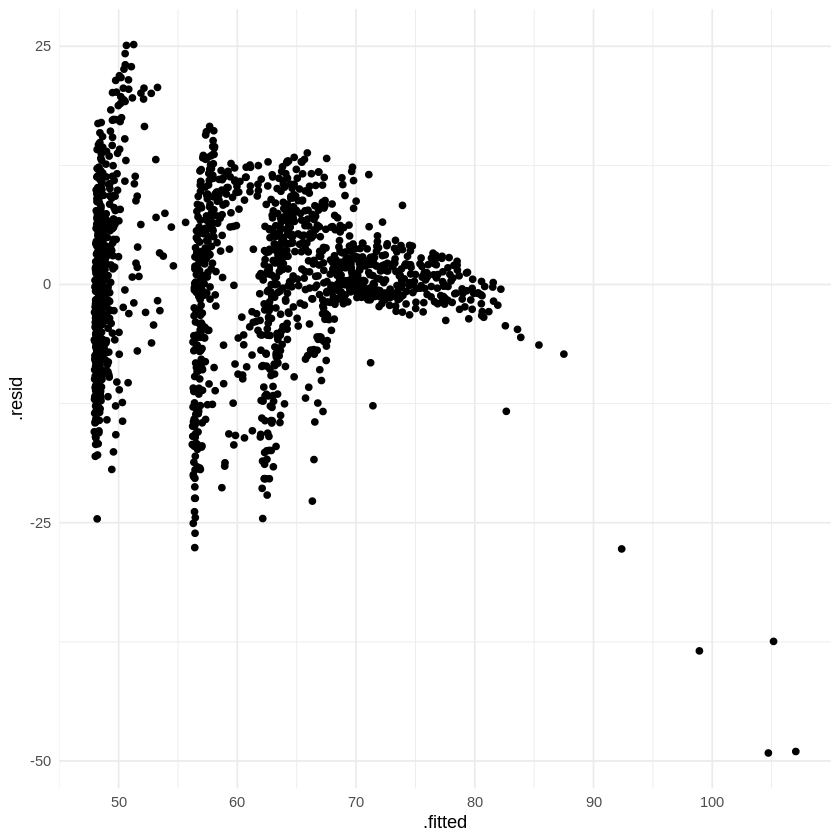

In [ ]:
p <- ggplot(data = out_aug,
            mapping = aes(x = .fitted, y = .resid))
p + geom_point() + theme_minimal()

### Obteniendo estadísticas a nivel de modelo con `glance()`

Esta función organiza la información que se presenta normalmente en la parte inferior de la salida de `summary()` de un modelo. Por sí solo, generalmente solo devuelve una tabla con una sola fila. Pero como veremos en un momento, el poder real del enfoque de `broom` es la forma en que puede escalar a los casos en los que agrupamos o submuestreamos nuestros datos.

In [ ]:
glance(out) %>% mutate(across(everything(), round, digits=3))

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.582,0.581,8.365,393.913,0,6,-6033.827,12083.65,12127.18,118754.5,1697,1704


`broom` puede ordenar (y aumentar) una amplia gama de tipos de modelos. No todas las funciones están disponibles para todas las clases de modelo. 

Pueden [consultar la documentación](https://broom.tidymodels.org/) de `broom` para obtener más detalles sobre lo que está disponible. 

Por ejemplo, aquí hay un gráfico creado a partir de la salida ordenada de un análisis del historial de eventos. Primero generamos un modelo de riesgos proporcionales de Cox de algunos datos de supervivencia.

In [ ]:
library(survival)

out_cph <- coxph(Surv(time, status) ~ age + sex, data = lung)
out_surv <- survfit(out_cph)

Los detalles del fiteo del modelo no son importantes aquí, pero en el primer paso, la función `Surv()` crea la variable de respuesta o resultado para el modelo de riesgos proporcionales que luego se ajusta mediante la función `coxph()`. 

Luego, la función `survfit()` crea la curva de supervivencia del modelo, al igual que usamos `predict()` para generar valores predichos anteriormente. Pruebe el resumen (`out_cph`) para ver el modelo y el resumen (`out_surv`) para ver la tabla de valores predichos que formarán la base de nuestro gráfico. A continuación, ordenamos `out_surv` para obtener un `data.frame` y lo ploteamos.


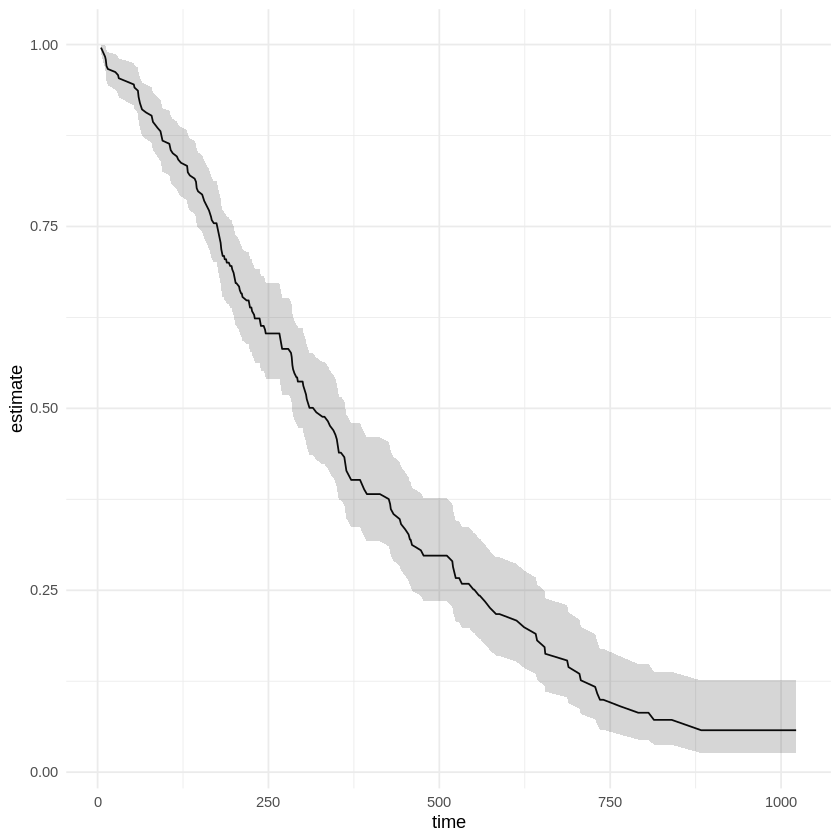

In [ ]:
out_tidy <- tidy(out_surv)

p <- ggplot(data = out_tidy, mapping = aes(time, estimate))
p + geom_line() +
    geom_ribbon(mapping = aes(ymin = conf.low, ymax = conf.high), alpha = .2) + theme_minimal()

## Análisis agrupado 

`broom` hace posible ajustar rápidamente modelos a diferentes subconjuntos de sus datos y obtener tablas de resultados consistentes y utilizables en el otro extremo. Por ejemplo, digamos que queríamos analizar los datos de `gapminder` examinando la relación entre la esperanza de vida -`lifeExp`- y el PIB por continente -`gdpPercap`-, para cada año -`year`-.

Los datos de `gapminder` están organizados en la parte inferior por país-año. Esa es la unidad de observación en las filas. Si quisiéramos, podríamos tomar una parte de los datos manualmente, como "todos los países observados en Asia, en 1962" o "todos en África, 2002". Aquí está "Europa, 1977":

In [ ]:
eu77 <- gapminder %>% filter(continent == "Europe", year == 1977)

Luego podemos ver cómo era la relación entre la esperanza de vida y el PIB para ese grupo continente-año:

In [ ]:
fit <- lm(lifeExp ~ log(gdpPercap), data = eu77)
summary(fit)


Call:
lm(formula = lifeExp ~ log(gdpPercap), data = eu77)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.4956 -1.0306  0.0935  1.1755  3.7125 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      29.489      7.161   4.118 0.000306 ***
log(gdpPercap)    4.488      0.756   5.936 2.17e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.114 on 28 degrees of freedom
Multiple R-squared:  0.5572,	Adjusted R-squared:  0.5414 
F-statistic: 35.24 on 1 and 28 DF,  p-value: 2.173e-06


Con `dplyr` y `broom` podemos hacer esto para cada segmento de datos de un año y continente de una manera compacta y ordenada. 

Comenzamos con nuestra tabla de datos, y luego (`%>%`) agrupamos los países por continente y año usando la función` group_by()`. 

Nuestros datos se reorganizan primero por continente y dentro de continente por año. 

Aquí daremos un paso más y anidaremos los datos que componen cada grupo:

In [ ]:
out_le <- gapminder %>%
    group_by(continent, year) %>%
    nest()

head(out_le)

continent,year,data
<fct>,<int>,<list>
Asia,1952,"1.000000e+00, 8.000000e+00, 9.000000e+00, 1.900000e+01, 2.500000e+01, 5.600000e+01, 5.900000e+01, 6.000000e+01, 6.100000e+01, 6.200000e+01, 6.400000e+01, 6.700000e+01, 6.800000e+01, 7.000000e+01, 7.100000e+01, 7.200000e+01, 7.300000e+01, 7.900000e+01, 8.400000e+01, 8.800000e+01, 9.000000e+01, 9.700000e+01, 9.800000e+01, 1.020000e+02, 1.100000e+02, 1.140000e+02, 1.200000e+02, 1.250000e+02, 1.260000e+02, 1.280000e+02, 1.380000e+02, 1.390000e+02, 1.400000e+02, 2.880100e+01, 5.093900e+01, 3.748400e+01, 3.941700e+01, 4.400000e+01, 6.096000e+01, 3.737300e+01, 3.746800e+01, 4.486900e+01, 4.532000e+01, 6.539000e+01, 6.303000e+01, 4.315800e+01, 5.005600e+01, 4.745300e+01, 5.556500e+01, 5.592800e+01, 4.846300e+01, 4.224400e+01, 3.631900e+01, 3.615700e+01, 3.757800e+01, 4.343600e+01, 4.775200e+01, 3.987500e+01, 6.039600e+01, 5.759300e+01, 4.588300e+01, 5.850000e+01, 5.084800e+01, 4.041200e+01, 4.316000e+01, 3.254800e+01, 8.425333e+06, 1.204470e+05, 4.688686e+07, 4.693836e+06, 5.562635e+08, 2.125900e+06, 3.720000e+08, 8.205200e+07, 1.727200e+07, 5.441766e+06, 1.620914e+06, 8.645902e+07, 6.079140e+05, 8.865488e+06, 2.094757e+07, 1.600000e+05, 1.439529e+06, 6.748378e+06, 8.006630e+05, 2.009300e+07, 9.182536e+06, 5.078330e+05, 4.134656e+07, 2.243869e+07, 4.005677e+06, 1.127000e+06, 7.982342e+06, 3.661549e+06, 8.550362e+06, 2.128940e+07, 2.624684e+07, 1.030585e+06, 4.963829e+06, 7.794453e+02, 9.867085e+03, 6.842442e+02, 3.684693e+02, 4.004486e+02, 3.054421e+03, 5.465657e+02, 7.496817e+02, 3.035326e+03, 4.129766e+03, 4.086522e+03, 3.216956e+03, 1.546908e+03, 1.088278e+03, 1.030592e+03, 1.083824e+05, 4.834804e+03, 1.831133e+03, 7.865669e+02, 3.310000e+02, 5.458657e+02, 1.828230e+03, 6.845971e+02, 1.272881e+03, 6.459555e+03, 2.315138e+03, 1.083532e+03, 1.643485e+03, 1.206948e+03, 7.577974e+02, 6.050665e+02, 1.515592e+03, 7.817176e+02"
Asia,1957,"1.000000e+00, 8.000000e+00, 9.000000e+00, 1.900000e+01, 2.500000e+01, 5.600000e+01, 5.900000e+01, 6.000000e+01, 6.100000e+01, 6.200000e+01, 6.400000e+01, 6.700000e+01, 6.800000e+01, 7.000000e+01, 7.100000e+01, 7.200000e+01, 7.300000e+01, 7.900000e+01, 8.400000e+01, 8.800000e+01, 9.000000e+01, 9.700000e+01, 9.800000e+01, 1.020000e+02, 1.100000e+02, 1.140000e+02, 1.200000e+02, 1.250000e+02, 1.260000e+02, 1.280000e+02, 1.380000e+02, 1.390000e+02, 1.400000e+02, 3.033200e+01, 5.383200e+01, 3.934800e+01, 4.136600e+01, 5.054896e+01, 6.475000e+01, 4.024900e+01, 3.991800e+01, 4.718100e+01, 4.843700e+01, 6.784000e+01, 6.550000e+01, 4.566900e+01, 5.408100e+01, 5.268100e+01, 5.803300e+01, 5.948900e+01, 5.210200e+01, 4.524800e+01, 4.190500e+01, 3.768600e+01, 4.008000e+01, 4.555700e+01, 5.133400e+01, 4.286800e+01, 6.317900e+01, 6.145600e+01, 4.828400e+01, 6.240000e+01, 5.363000e+01, 4.288700e+01, 4.567100e+01, 3.397000e+01, 9.240934e+06, 1.386550e+05, 5.136547e+07, 5.322536e+06, 6.374080e+08, 2.736300e+06, 4.090000e+08, 9.012400e+07, 1.979200e+07, 6.248643e+06, 1.944401e+06, 9.156301e+07, 7.465590e+05, 9.411381e+06, 2.261155e+07, 2.128460e+05, 1.647412e+06, 7.739235e+06, 8.821340e+05, 2.173184e+07, 9.682338e+06, 5.619770e+05, 4.667994e+07, 2.607219e+07, 4.419650e+06, 1.445929e+06, 9.128546e+06, 4.149908e+06, 1.016422e+07, 2.504192e+07, 2.899854e+07, 1.070439e+06, 5.498090e+06, 8.208530e+02, 1.163580e+04, 6.616375e+02, 4.340383e+02, 5.759870e+02, 3.629076e+03, 5.900620e+02, 8.589003e+02, 3.290258e+03, 6.229334e+03, 5.385278e+03, 4.317694e+03, 1.886081e+03, 1.571135e+03, 1.487594e+03, 1.135231e+05, 6.089787e+03, 1.810067e+03, 9.126626e+02, 3.500000e+02, 5.979364e+02, 2.242747e+03, 7.470835e+02, 1.547945e+03, 8.157591e+03, 2.843104e+03, 1.072547e+03, 2.117235e+03, 1.507861e+03, 7.935774e+02, 6.762854e+02, 1.827068e+03, 8.048305e+02"
Asia,1962,"1.000000e+00, 8.000000e+00, 9.000000e+00, 1.900000e+01, 2.500000e+01, 5.600000e+01, 5.900000e+01, 6.000000e+01, 6.100000e+01, 6.200000e+01, 6.400000e+01, 6.700000e+01, 6.800000e+01, 7.000000e+01, 7.100000e+01, 7.200000e+01, 7.300000

Pensemos en lo que hace `nest()` como una versión recargada de `group_by()`. 

El objeto resultante tiene la forma tabular que esperamos (es una `tibble`) pero parece un poco inusual. 

Las dos primeras columnas son el `continent` y el `year` familiares. Pero ahora también tenemos una nueva columna, `data`, que contiene una pequeña tabla de datos correspondiente a cada grupo continente-año. 

Esta es una columna de lista, algo que no hemos visto antes. Resulta muy útil para agrupar objetos complejos (estructurados, en este caso, como una lista de `tibbles`, cada uno de los cuales es una tabla de datos de 33x4) dentro de las filas de nuestros datos (que sigue siendo tabular). 

Nuestro ajuste de "Europa 1977" está ahí. Podemos verlo, si queremos, filtrando los datos y luego desanidando la columna de la lista.

In [ ]:
out_le %>% filter(continent == "Europe" & year == 1977) %>% unnest()

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(data)`”


continent,year,country,lifeExp,pop,gdpPercap
<fct>,<int>,<fct>,<dbl>,<int>,<dbl>
Europe,1977,Albania,68.930,2509048,3533.004
Europe,1977,Austria,72.170,7568430,19749.422
Europe,1977,Belgium,72.800,9821800,19117.974
Europe,1977,Bosnia and Herzegovina,69.860,4086000,3528.481
Europe,1977,Bulgaria,70.810,8797022,7612.240
Europe,1977,Croatia,70.640,4318673,11305.385
Europe,1977,Czech Republic,70.710,10161915,14800.161
Europe,1977,Denmark,74.690,5088419,20422.901
Europe,1977,Finland,72.520,4738902,15605.423


Las columnas de lista son útiles porque podemos actuar sobre ellas de forma compacta y ordenada. En particular, podemos pasar funciones a cada fila de la columna de la lista y hacer que suceda algo. 

Por ejemplo, hace un momento hicimos una regresión de la esperanza de vida y registramos el PIB de los países europeos en 1977. Podemos hacer eso para cada combinación continente-año en los datos. 

Primero creamos una función ad-hoc llamada `fit_ols()` que toma un solo argumento, `df` (para el marco de datos) y que se ajusta al modelo lineal que nos interesa.

Entonces, mapeamos esa función para cada fila de `out_le`. Es decir, aplicamos esa función para cada una de las filas y para cada fila (que contiene una `tibble`), fiteamos un modelo. 

"Mapear" es una idea importante en la programación funcional. Si han escrito código en otros lenguajes, puede pensar en él como una alternativa compacta a escribir un `for` loop. Por supuesto, podríamos hacer esto escribiendo un for loop. 

Computacionalmente, a menudo no son menos eficientes que sus alternativas funcionales. Pero la asignación de funciones a matrices se integra más fácilmente en una secuencia de transformaciones de datos.

In [ ]:
fit_ols <- function(df) {
    lm(lifeExp ~ log(gdpPercap), data = df)
}

out_le <- gapminder %>%
    group_by(continent, year) %>%
    nest() %>% 
    mutate(model = map(data, fit_ols)) 

head(out_le)

continent,year,data,model
<fct>,<int>,<list>,<list>
Asia,1952,"1.000000e+00, 8.000000e+00, 9.000000e+00, 1.900000e+01, 2.500000e+01, 5.600000e+01, 5.900000e+01, 6.000000e+01, 6.100000e+01, 6.200000e+01, 6.400000e+01, 6.700000e+01, 6.800000e+01, 7.000000e+01, 7.100000e+01, 7.200000e+01, 7.300000e+01, 7.900000e+01, 8.400000e+01, 8.800000e+01, 9.000000e+01, 9.700000e+01, 9.800000e+01, 1.020000e+02, 1.100000e+02, 1.140000e+02, 1.200000e+02, 1.250000e+02, 1.260000e+02, 1.280000e+02, 1.380000e+02, 1.390000e+02, 1.400000e+02, 2.880100e+01, 5.093900e+01, 3.748400e+01, 3.941700e+01, 4.400000e+01, 6.096000e+01, 3.737300e+01, 3.746800e+01, 4.486900e+01, 4.532000e+01, 6.539000e+01, 6.303000e+01, 4.315800e+01, 5.005600e+01, 4.745300e+01, 5.556500e+01, 5.592800e+01, 4.846300e+01, 4.224400e+01, 3.631900e+01, 3.615700e+01, 3.757800e+01, 4.343600e+01, 4.775200e+01, 3.987500e+01, 6.039600e+01, 5.759300e+01, 4.588300e+01, 5.850000e+01, 5.084800e+01, 4.041200e+01, 4.316000e+01, 3.254800e+01, 8.425333e+06, 1.204470e+05, 4.688686e+07, 4.693836e+06, 5.562635e+08, 2.125900e+06, 3.720000e+08, 8.205200e+07, 1.727200e+07, 5.441766e+06, 1.620914e+06, 8.645902e+07, 6.079140e+05, 8.865488e+06, 2.094757e+07, 1.600000e+05, 1.439529e+06, 6.748378e+06, 8.006630e+05, 2.009300e+07, 9.182536e+06, 5.078330e+05, 4.134656e+07, 2.243869e+07, 4.005677e+06, 1.127000e+06, 7.982342e+06, 3.661549e+06, 8.550362e+06, 2.128940e+07, 2.624684e+07, 1.030585e+06, 4.963829e+06, 7.794453e+02, 9.867085e+03, 6.842442e+02, 3.684693e+02, 4.004486e+02, 3.054421e+03, 5.465657e+02, 7.496817e+02, 3.035326e+03, 4.129766e+03, 4.086522e+03, 3.216956e+03, 1.546908e+03, 1.088278e+03, 1.030592e+03, 1.083824e+05, 4.834804e+03, 1.831133e+03, 7.865669e+02, 3.310000e+02, 5.458657e+02, 1.828230e+03, 6.845971e+02, 1.272881e+03, 6.459555e+03, 2.315138e+03, 1.083532e+03, 1.643485e+03, 1.206948e+03, 7.577974e+02, 6.050665e+02, 1.515592e+03, 7.817176e+02","15.83231, 4.159673, -14.72884, -3.149655, -5.503966, -0.9963051, 3.240493, 11.74904, -4.680453, -5.899884, -4.315877, -5.145648, 14.96814, 13.60338, -3.223004, 5.137793, 2.76134, -8.492148, 4.806705, 1.380355, -1.32367, -3.648226, -5.891122, -9.498046, 0.4458891, 2.182029, -12.45143, 12.33777, 12.69297, -0.7499191, 13.15127, 7.435327, -2.064424, -3.135932, -10.99395, -266.0559, -26.95474, -3.400234, 1.036664, 5.282978, 14.0238, -2.602405, -3.785711, -2.041828, -2.836398, 17.27619, 15.88407, -1.026017, 7.294576, 4.911897, -5.809347, 7.133975, 3.596626, 0.7959949, -1.627517, -3.813221, -7.281956, 2.54968, 4.356725, -10.09104, 14.58085, 14.84926, 1.453991, 15.31989, 9.550731, 0.0252488, -0.9412834, -8.874988, 2, 43.52984, 54.08866, 42.98797, 40.41331, 40.75951, 49.21096, 42.05345, 43.36788, 49.18488, 50.46565, 50.42186, 49.42662, 46.381, 44.91821, 44.69166, 64.05715, 51.1213, 47.08264, 43.56767, 39.96723, 42.04812, 47.07605, 42.99011, 45.56997, 52.32643, 48.05823, 44.90003, 46.63292, 45.34873, 43.41267, 42.47642, 46.29593, 43.54195, 0, 1, -5.744563, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, -42.09615, -6.480015, -0.1080911, -0.203609, -0.1907652, 0.1227772, -0.1427608, -0.09399644, 0.1218095, 0.1693251, 0.1677006, 0.1307781, 0.01778796, -0.03648068, -0.04488541, 0.6735592, 0.1936491, 0.04381828, -0.08658457, -0.2201582, -0.1429586, 0.04357347, -0.1080116, -0.01230073, 0.2383588, 0.0800118, -0.0371551, 0.02713381, -0.02050874, -0.09233481, -0.1270689, 0.01463185, -0.08753892, 1.174078, 1.303736, 1, 2, 1e-07, 2, 31, lm(formula = lifeExp ~ log(gdpPercap), data = df), lifeExp ~ log(gdpPercap), 28.801, 50.939, 37.484, 39.417, 44, 60.96, 37.373, 37.468, 44.869, 45.32, 65.39, 63.03, 43.158, 50.056, 47.453, 55.565, 55.928, 48.463, 42.244, 36.319, 36.157, 37.5

Antes de meternos adentro de todo esto, creemos una nueva función: su único trabajo es estimar un modelo MCO particular en algunos datos. 

Como casi todo en R, las funciones son una especie de objeto. Para hacer uno nuevo, usamos la función `function()` ligeramente especial. 

(A los nerds les encanta ese tipo de cosas). 

Para ver cómo se ve `fit_ols()` una vez creado, podemos escribir `fit_ols` sin paréntesis en la consola. Para ver lo que hace, pruebe` fit_ols (df = gapminder)` o `summary(fit_ols (gapminder))`.

Ahora tenemos dos columnas de lista: `data` y `model`. Esta última fue creada mapeando la función `fit_ols()` a cada fila de datos. 

Dentro de cada elemento de `model` hay un objeto de modelo lineal para ese continente-año. Así que ahora tenemos sesenta ajustes de MCO, uno para cada grupo continente-año. 

Tener los modelos dentro de la columna `model` no nos sirve de mucho en sí mismo. Pero podemos extraer la información que queremos mientras mantenemos las cosas en una forma tabular ordenada. Para mayor claridad, ejecutaremos el pipelinedesde el principio nuevamente, esta vez agregando algunos pasos nuevos.


In [ ]:
fit_ols <- function(df) {
    lm(lifeExp ~ log(gdpPercap), data = df)
}

out_tidy <- gapminder %>%
    group_by(continent, year) %>%
    nest() %>% 
    mutate(model = map(data, fit_ols),
           tidied = map(model, tidy)) %>%
    unnest(tidied, .drop=TRUE) %>%
    filter(! (term %in% "(Intercept)") & ! (continent %in% "Oceania"))


out_tidy %>% head(5)

continent,year,data,model,term,estimate,std.error,statistic,p.value
<fct>,<int>,<list>,<list>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Asia,1952,"1.000000e+00, 8.000000e+00, 9.000000e+00, 1.900000e+01, 2.500000e+01, 5.600000e+01, 5.900000e+01, 6.000000e+01, 6.100000e+01, 6.200000e+01, 6.400000e+01, 6.700000e+01, 6.800000e+01, 7.000000e+01, 7.100000e+01, 7.200000e+01, 7.300000e+01, 7.900000e+01, 8.400000e+01, 8.800000e+01, 9.000000e+01, 9.700000e+01, 9.800000e+01, 1.020000e+02, 1.100000e+02, 1.140000e+02, 1.200000e+02, 1.250000e+02, 1.260000e+02, 1.280000e+02, 1.380000e+02, 1.390000e+02, 1.400000e+02, 2.880100e+01, 5.093900e+01, 3.748400e+01, 3.941700e+01, 4.400000e+01, 6.096000e+01, 3.737300e+01, 3.746800e+01, 4.486900e+01, 4.532000e+01, 6.539000e+01, 6.303000e+01, 4.315800e+01, 5.005600e+01, 4.745300e+01, 5.556500e+01, 5.592800e+01, 4.846300e+01, 4.224400e+01, 3.631900e+01, 3.615700e+01, 3.757800e+01, 4.343600e+01, 4.775200e+01, 3.987500e+01, 6.039600e+01, 5.759300e+01, 4.588300e+01, 5.850000e+01, 5.084800e+01, 4.041200e+01, 4.316000e+01, 3.254800e+01, 8.425333e+06, 1.204470e+05, 4.688686e+07, 4.693836e+06, 5.562635e+08, 2.125900e+06, 3.720000e+08, 8.205200e+07, 1.727200e+07, 5.441766e+06, 1.620914e+06, 8.645902e+07, 6.079140e+05, 8.865488e+06, 2.094757e+07, 1.600000e+05, 1.439529e+06, 6.748378e+06, 8.006630e+05, 2.009300e+07, 9.182536e+06, 5.078330e+05, 4.134656e+07, 2.243869e+07, 4.005677e+06, 1.127000e+06, 7.982342e+06, 3.661549e+06, 8.550362e+06, 2.128940e+07, 2.624684e+07, 1.030585e+06, 4.963829e+06, 7.794453e+02, 9.867085e+03, 6.842442e+02, 3.684693e+02, 4.004486e+02, 3.054421e+03, 5.465657e+02, 7.496817e+02, 3.035326e+03, 4.129766e+03, 4.086522e+03, 3.216956e+03, 1.546908e+03, 1.088278e+03, 1.030592e+03, 1.083824e+05, 4.834804e+03, 1.831133e+03, 7.865669e+02, 3.310000e+02, 5.458657e+02, 1.828230e+03, 6.845971e+02, 1.272881e+03, 6.459555e+03, 2.315138e+03, 1.083532e+03, 1.643485e+03, 1.206948e+03, 7.577974e+02, 6.050665e+02, 1.515592e+03, 7.817176e+02","15.83231, 4.159673, -14.72884, -3.149655, -5.503966, -0.9963051, 3.240493, 11.74904, -4.680453, -5.899884, -4.315877, -5.145648, 14.96814, 13.60338, -3.223004, 5.137793, 2.76134, -8.492148, 4.806705, 1.380355, -1.32367, -3.648226, -5.891122, -9.498046, 0.4458891, 2.182029, -12.45143, 12.33777, 12.69297, -0.7499191, 13.15127, 7.435327, -2.064424, -3.135932, -10.99395, -266.0559, -26.95474, -3.400234, 1.036664, 5.282978, 14.0238, -2.602405, -3.785711, -2.041828, -2.836398, 17.27619, 15.88407, -1.026017, 7.294576, 4.911897, -5.809347, 7.133975, 3.596626, 0.7959949, -1.627517, -3.813221, -7.281956, 2.54968, 4.356725, -10.09104, 14.58085, 14.84926, 1.453991, 15.31989, 9.550731, 0.0252488, -0.9412834, -8.874988, 2, 43.52984, 54.08866, 42.98797, 40.41331, 40.75951, 49.21096, 42.05345, 43.36788, 49.18488, 50.46565, 50.42186, 49.42662, 46.381, 44.91821, 44.69166, 64.05715, 51.1213, 47.08264, 43.56767, 39.96723, 42.04812, 47.07605, 42.99011, 45.56997, 52.32643, 48.05823, 44.90003, 46.63292, 45.34873, 43.41267, 42.47642, 46.29593, 43.54195, 0, 1, -5.744563, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, -42.09615, -6.480015, -0.1080911, -0.203609, -0.1907652, 0.1227772, -0.1427608, -0.09399644, 0.1218095, 0.1693251, 0.1677006, 0.1307781, 0.01778796, -0.03648068, -0.04488541, 0.6735592, 0.1936491, 0.04381828, -0.08658457, -0.2201582, -0.1429586, 0.04357347, -0.1080116, -0.01230073, 0.2383588, 0.0800118, -0.0371551, 0.02713381, -0.02050874, -0.09233481, -0.1270689, 0.01463185, -0.08753892, 1.174078, 1.303736, 1, 2, 1e-07, 2, 31, lm(formula = lifeExp ~ log(gdpPercap), data = df), lifeExp ~ log(gdpPercap), 28.801, 50.939, 37.484, 39.417, 44, 60.96, 37.373, 37.468, 44.869, 45.32, 65.39, 63.03, 43.1

In [ ]:
out_tidy

continent,year,data,model,term,estimate,std.error,statistic,p.value
<fct>,<int>,<list>,<list>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Asia,1952,"1.000000e+00, 8.000000e+00, 9.000000e+00, 1.900000e+01, 2.500000e+01, 5.600000e+01, 5.900000e+01, 6.000000e+01, 6.100000e+01, 6.200000e+01, 6.400000e+01, 6.700000e+01, 6.800000e+01, 7.000000e+01, 7.100000e+01, 7.200000e+01, 7.300000e+01, 7.900000e+01, 8.400000e+01, 8.800000e+01, 9.000000e+01, 9.700000e+01, 9.800000e+01, 1.020000e+02, 1.100000e+02, 1.140000e+02, 1.200000e+02, 1.250000e+02, 1.260000e+02, 1.280000e+02, 1.380000e+02, 1.390000e+02, 1.400000e+02, 2.880100e+01, 5.093900e+01, 3.748400e+01, 3.941700e+01, 4.400000e+01, 6.096000e+01, 3.737300e+01, 3.746800e+01, 4.486900e+01, 4.532000e+01, 6.539000e+01, 6.303000e+01, 4.315800e+01, 5.005600e+01, 4.745300e+01, 5.556500e+01, 5.592800e+01, 4.846300e+01, 4.224400e+01, 3.631900e+01, 3.615700e+01, 3.757800e+01, 4.343600e+01, 4.775200e+01, 3.987500e+01, 6.039600e+01, 5.759300e+01, 4.588300e+01, 5.850000e+01, 5.084800e+01, 4.041200e+01, 4.316000e+01, 3.254800e+01, 8.425333e+06, 1.204470e+05, 4.688686e+07, 4.693836e+06, 5.562635e+08, 2.125900e+06, 3.720000e+08, 8.205200e+07, 1.727200e+07, 5.441766e+06, 1.620914e+06, 8.645902e+07, 6.079140e+05, 8.865488e+06, 2.094757e+07, 1.600000e+05, 1.439529e+06, 6.748378e+06, 8.006630e+05, 2.009300e+07, 9.182536e+06, 5.078330e+05, 4.134656e+07, 2.243869e+07, 4.005677e+06, 1.127000e+06, 7.982342e+06, 3.661549e+06, 8.550362e+06, 2.128940e+07, 2.624684e+07, 1.030585e+06, 4.963829e+06, 7.794453e+02, 9.867085e+03, 6.842442e+02, 3.684693e+02, 4.004486e+02, 3.054421e+03, 5.465657e+02, 7.496817e+02, 3.035326e+03, 4.129766e+03, 4.086522e+03, 3.216956e+03, 1.546908e+03, 1.088278e+03, 1.030592e+03, 1.083824e+05, 4.834804e+03, 1.831133e+03, 7.865669e+02, 3.310000e+02, 5.458657e+02, 1.828230e+03, 6.845971e+02, 1.272881e+03, 6.459555e+03, 2.315138e+03, 1.083532e+03, 1.643485e+03, 1.206948e+03, 7.577974e+02, 6.050665e+02, 1.515592e+03, 7.817176e+02","15.83231, 4.159673, -14.72884, -3.149655, -5.503966, -0.9963051, 3.240493, 11.74904, -4.680453, -5.899884, -4.315877, -5.145648, 14.96814, 13.60338, -3.223004, 5.137793, 2.76134, -8.492148, 4.806705, 1.380355, -1.32367, -3.648226, -5.891122, -9.498046, 0.4458891, 2.182029, -12.45143, 12.33777, 12.69297, -0.7499191, 13.15127, 7.435327, -2.064424, -3.135932, -10.99395, -266.0559, -26.95474, -3.400234, 1.036664, 5.282978, 14.0238, -2.602405, -3.785711, -2.041828, -2.836398, 17.27619, 15.88407, -1.026017, 7.294576, 4.911897, -5.809347, 7.133975, 3.596626, 0.7959949, -1.627517, -3.813221, -7.281956, 2.54968, 4.356725, -10.09104, 14.58085, 14.84926, 1.453991, 15.31989, 9.550731, 0.0252488, -0.9412834, -8.874988, 2, 43.52984, 54.08866, 42.98797, 40.41331, 40.75951, 49.21096, 42.05345, 43.36788, 49.18488, 50.46565, 50.42186, 49.42662, 46.381, 44.91821, 44.69166, 64.05715, 51.1213, 47.08264, 43.56767, 39.96723, 42.04812, 47.07605, 42.99011, 45.56997, 52.32643, 48.05823, 44.90003, 46.63292, 45.34873, 43.41267, 42.47642, 46.29593, 43.54195, 0, 1, -5.744563, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, 0.1740777, -42.09615, -6.480015, -0.1080911, -0.203609, -0.1907652, 0.1227772, -0.1427608, -0.09399644, 0.1218095, 0.1693251, 0.1677006, 0.1307781, 0.01778796, -0.03648068, -0.04488541, 0.6735592, 0.1936491, 0.04381828, -0.08658457, -0.2201582, -0.1429586, 0.04357347, -0.1080116, -0.01230073, 0.2383588, 0.0800118, -0.0371551, 0.02713381, -0.02050874, -0.09233481, -0.1270689, 0.01463185, -0.08753892, 1.174078, 1.303736, 1, 2, 1e-07, 2, 31, lm(formula = lifeExp ~ log(gdpPercap), data = df), lifeExp ~ log(gdpPercap), 28.801, 50.939, 37.484, 39.417, 44, 60.96, 37.373, 37.468, 44.869, 45.32, 65.39, 63.03, 43.1

1. extraemos estadísticas de resumen de cada modelo mapeando la función `tidy()` de `broom` a `model` (columna-lista que tiene todos los objetos de modelos lineales). 

2. hacmeos `unnest()` sobre el resultado y descartamos las otras columnas en el proceso

3. filtramos todos los términos de interceptoy también descartamos todas las observaciones de Oceanía.  En el caso de los `Intercepts`, lo hacemos solo por conveniencia. Oceanía abandonamos solo porque hay muy pocas observaciones. 

4. guardamos los resultados en un objeto llamado `out_tidy`.

Ahora tenemos un resultado de regresión ordenado con una estimación de la asociación entre el logaritmo del PIB per cápita y la esperanza de vida para cada año, dentro de los continentes. Podemos graficar estas estimaciones de una manera que aproveche su grupo.

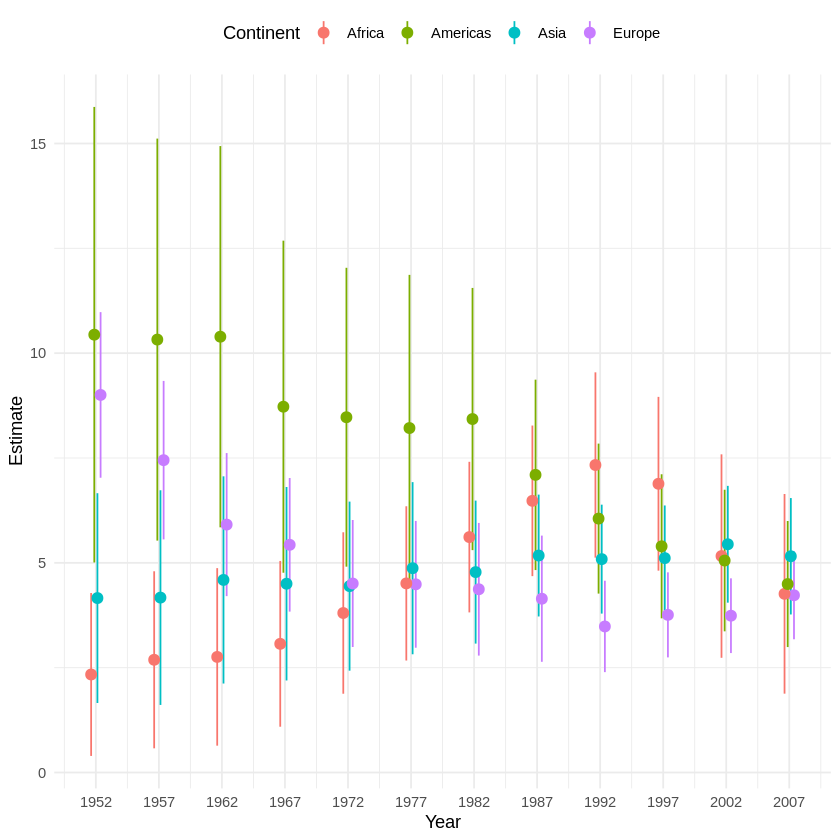

In [ ]:
p <- ggplot(data = out_tidy,
            mapping = aes(x = year, 
                          y = estimate,
                          ymin = estimate - 2*std.error,
                          ymax = estimate + 2*std.error,
                          group = continent, 
                          color = continent))

p + geom_pointrange(position = position_dodge(width = 1)) +
    scale_x_continuous(breaks = unique(gapminder$year)) + 
    labs(x = "Year", y = "Estimate", color = "Continent") + 
    theme_minimal() +
    theme(legend.position = 'top')

La llamada a` position_dodge()` dentro de `geom_pointrange()` permite que los rangos de puntos de cada continente estén cerca unos de otros en años, en lugar de estar graficados uno encima del otro. 

Esta técnica es muy útil no solo para casos como este, sino también cuando desea comparar los coeficientes dados por diferentes tipos de modelo estadístico. 

Esto a veces sucede cuando estamos interesados ​​en ver cómo, por ejemplo, OLS se desempeña en comparación con alguna otra especificación del modelo.



---
## Actividad

¿De qué otra forma podríamos haber armado este plot? Armen el código para hacerlo...

In [ ]:
###

---

## Graficando efectos marginales

Hasta ahora, nuestro uso de  `predict()` trataba de obtener estimaciones del efecto promedio de algún coeficiente, neto de los otros términos del modelo, como en cualquier regresión lineal.

Durante la última década, estimar y graficar efectos parciales o marginales de un modelo se ha convertido en una forma cada vez más común de presentar predicciones precisas e interpretativamente útiles. Particularmente, en modelos de Machine Learning.

El interés en las gráficas de efectos marginales se estimuló al darse cuenta de que la interpretación de los términos en los modelos de regresión logística, en particular, era más complicada de lo que parecía, especialmente cuando había términos de interacción en el modelo. El paquete `margins` de Thomas Leeper puede ayudarnos mucho.

Para ver esto, vamos usar un dataset que contiene algunas características (género, edad, bloque y región) de la votación de la Ley de Interrupción Voluntaria del Embarzo que se produjo el año pasado.  

Vamos a cargar los datos y vamos a trasnformar en factor la variable dependiente (`votacion_final1`).


In [ ]:
dip <- read_csv('https://github.com/gefero/idaes_viz/blob/main/data/proc/diputados_IVE.csv?raw=true')

dip <- dip %>%
  mutate(votacion_final1 = as.factor(votacion_final1))


── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_double(),
  genero = col_character(),
  edad = col_double(),
  provincia = col_character(),
  bloque = col_character(),
  votacion_final1 = col_character(),
  region = col_character()
)




Estimemos, entonces, un modelo de regresión logística. En este modelo vamos a insertar todos las variables y dos bloques de interacción: entre `genero` y `edad` y entre `bloque` y `provincia`

In [ ]:
out_bo <- glm(votacion_final1 ~ genero + edad + bloque  + region + genero*edad + region*bloque,
              family = "binomial", data = dip)
summary(out_bo)


Call:
glm(formula = votacion_final1 ~ genero + edad + bloque + region + 
    genero * edad + region * bloque, family = "binomial", data = dip)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.53747  -0.72440   0.00013   0.68327   2.15684  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                   4.91198    1.37045   3.584
generoVarón                                  -0.65744    1.58008  -0.416
edad                                         -0.05417    0.02350  -2.305
bloqueJxC y aliados                          -2.39342    0.70821  -3.380
bloqueresto y provinciales                   -0.83887    0.87014  -0.964
regionCABA                                   -0.12381    1.24010  -0.100
regionCentro                                 -0.32414    0.94937  -0.341
regionCuyo                                   -2.68530    0.87814  -3.058
regionNEA                                    -3.29236    0.8

The summary reports the coefficients and other information. We can now graph the data in any one of several ways. Using margins() we calculate the marginal effects for each variable:

La función `summary()`, como hemos visto, reporta los coeficientes y alguna otra informacipon. Ahora bien, sobre esta base tenemos varias opciones para graficar información de este modelo. 

Podmeos usar `margins()` para calcular los efectos marginales de cada una de las variables predictoras:

In [ ]:
library(margins)

In [ ]:
bo_m <- margins(out_bo)
summary(bo_m)

,factor,AME,SE,z,p,lower,upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,bloqueJxC y aliados,-0.546078508,0.048588708,-11.23879458,2.629482e-29,-0.64131063,-0.450846391
2,bloqueresto y provinciales,-0.187753760,0.060150004,-3.12142554,1.799778e-03,-0.30564560,-0.069861918
3,edad,-0.006879771,0.002011876,-3.41957965,6.271797e-04,-0.01082298,-0.002936566
4,generoVarón,0.003688406,0.050866959,0.07251085,9.421954e-01,-0.09600900,0.103385814
5,regionCABA,0.028625801,0.083215961,0.34399411,7.308507e-01,-0.13447449,0.191726088
6,regionCentro,-0.194026632,0.074564226,-2.60214103,9.264375e-03,-0.34016983,-0.047883434
7,regionCuyo,-0.454452634,0.094196928,-4.82449529,1.403582e-06,-0.63907522,-0.269830048
8,regionNEA,-0.583420917,0.080756456,-7.22444924,5.031367e-13,-0.74170066,-0.425141172
9,regionNOA,-0.444088656,0.074538089,-5.95787549,2.555381e-09,-0.59018063,-0.297996685


La librería `margins` trae varios métodos de gráficació propios. Por ejemplo, podríamos probar lo siguiente:

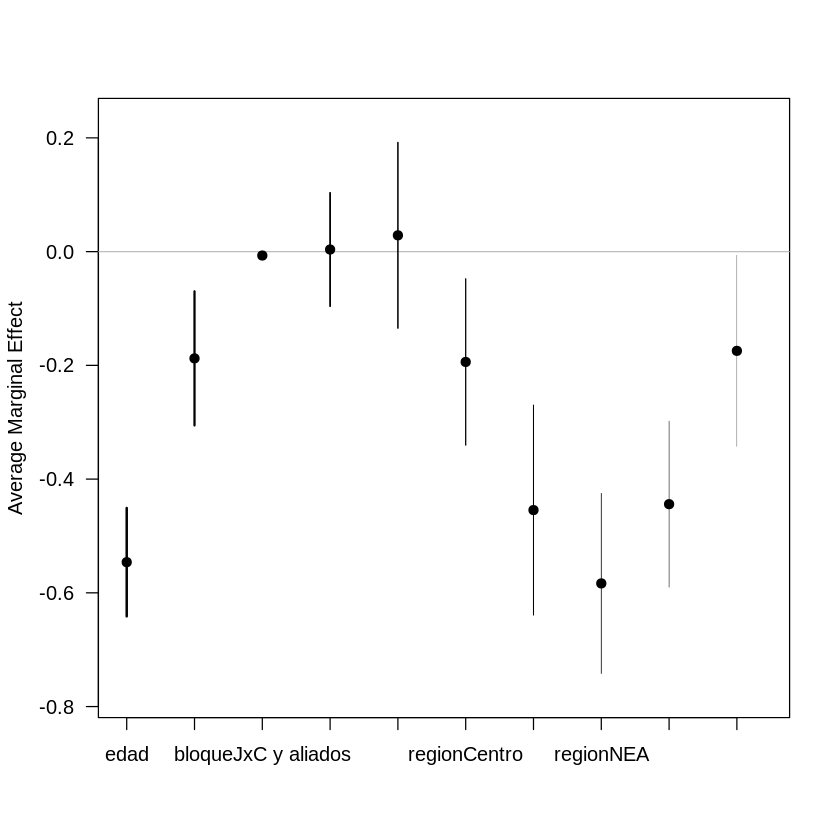

In [ ]:
plot(bo_m)

Y vemos un gráfico de los efectos marginales promedio, inspirado en el diseño de stata. De hecho, si consultan el [sitio del paquete](https://thomasleeper.com/margins/index.html) van a poder ver que el autor intentó replicar la lógica del comando `margins` de Stata.

Otros métodos de visualización en la librería son 
- `cplot()`, que visualiza los efectos marginales condicionados a una segunda variable
- `image(),` que muestra predicciones o efectos marginales como un mapa de calor relleno o un gráfico de contorno.

También, podemos tomar los resultados de `margins` y graficarlos nosotros mismos. 

1. Convertimos la salida del `summary()` en una `tibble`
2. Usamos `mutate(factor=str_replace_all(...)` para ordenar las etiquetas. Queremos eliminar los prefijos `bloque`, `genero` y `region` para ajustarlos y hacerlos más prolijos:

In [ ]:
bo_gg <- as_tibble(summary(bo_m))
prefixes <- c("bloque", "genero", "region")
replacement <- c("Bloque: ", "Genero: ", "Region: ")

bo_gg <- bo_gg %>% 
      mutate(factor = str_replace_all(factor, c("bloque"="Bloque: ",
                                                "genero"="Género: ",
                                                "region"="Región: ", 
                                                "edad"="Edad")))

bo_gg %>% select(factor, AME, lower, upper) 

factor,AME,lower,upper
<chr>,<dbl>,<dbl>,<dbl>
Bloque: JxC y aliados,-0.546078508,-0.64131063,-0.450846391
Bloque: resto y provinciales,-0.187753760,-0.30564560,-0.069861918
Edad,-0.006879771,-0.01082298,-0.002936566
Género: Varón,0.003688406,-0.09600900,0.103385814
Región: CABA,0.028625801,-0.13447449,0.191726088
Región: Centro,-0.194026632,-0.34016983,-0.047883434
Región: Cuyo,-0.454452634,-0.63907522,-0.269830048
Región: NEA,-0.583420917,-0.74170066,-0.425141172
Región: NOA,-0.444088656,-0.59018063,-0.297996685


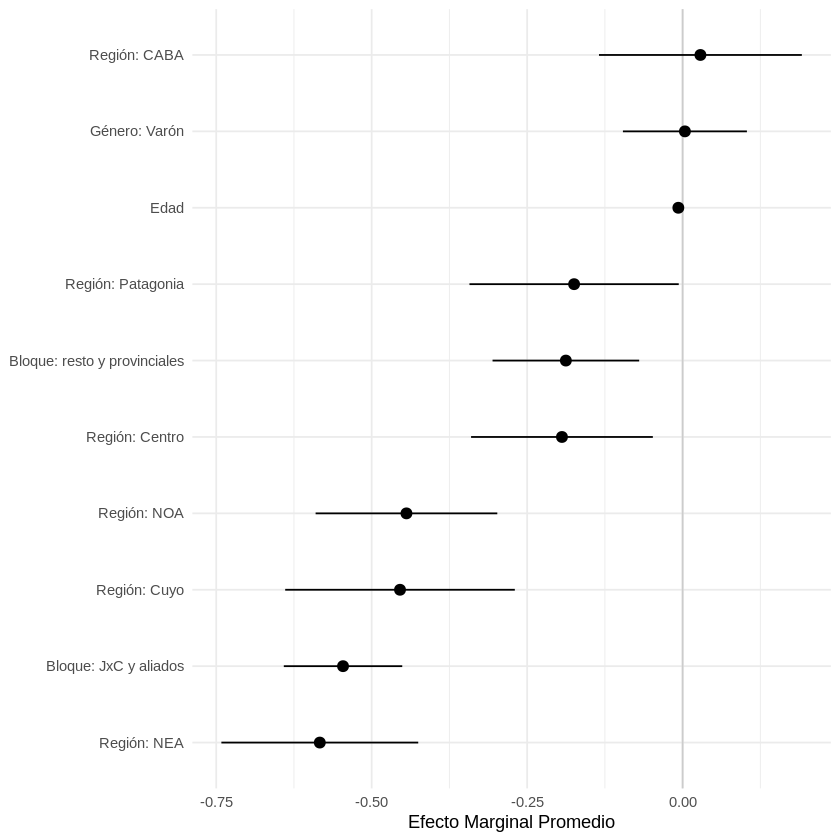

In [ ]:
p <- ggplot(data = bo_gg, aes(x = reorder(factor, AME),
                              y = AME, ymin = lower, ymax = upper))

p + geom_hline(yintercept = 0, color = "gray80") +
    geom_pointrange() + coord_flip() +
    labs(x = NULL, y = "Efecto Marginal Promedio") +
    theme_minimal()

Si solo estamos interesados ​​en obtener efectos condicionales para una variable en particular, entonces convenientemente podemos pedir a los métodos de la librería que hagan el trabajo de calcular los efectos por nosotros, pero sin dibujar el gráfico. 

Pueden devolver los resultados en un formato que podemos reusar fácilmente en `ggplot`, y con menos necesidad de limpieza, para la limpieza. Por ejemplo, con `cplot()`:

In [ ]:
pv_cp <- cplot(out_bo, x = "bloque", draw = FALSE)
pv_cp

,xvals,yvals,upper,lower
,<chr>,<dbl>,<dbl>,<dbl>
1,FDT,0.8914640,1.0004901,0.7824378
2,JxC y aliados,0.4285822,0.6550378,0.2021266
3,resto y provinciales,0.7802142,1.0082583,0.5521702


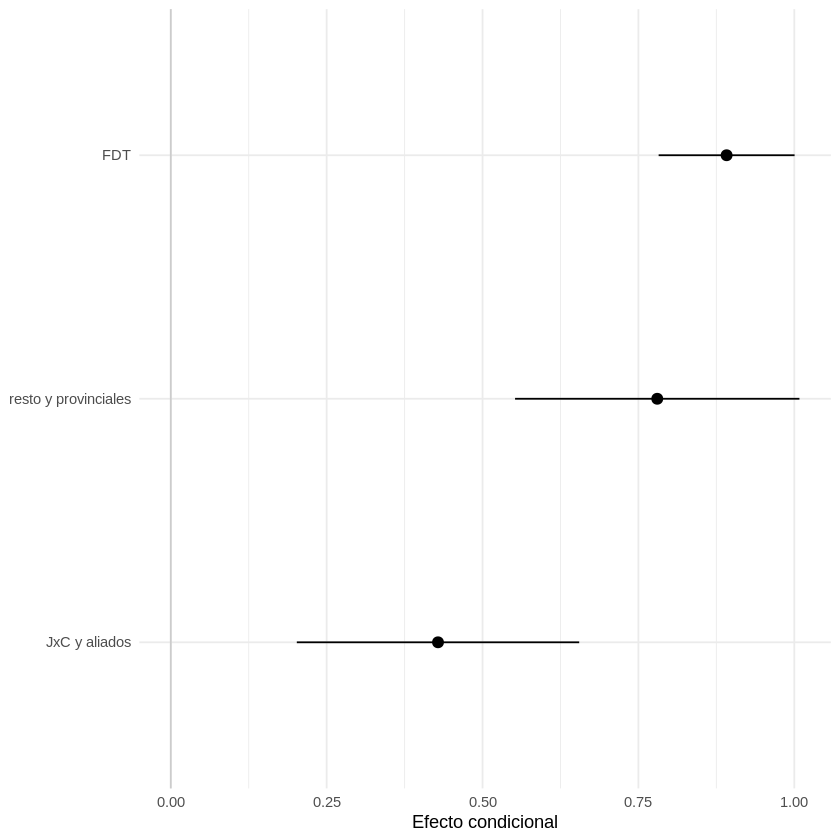

In [ ]:

p <- ggplot(data = pv_cp, aes(x = reorder(xvals, yvals),
                              y = yvals, 
                              ymin = lower, 
                              ymax = upper))

p + geom_hline(yintercept = 0, color = "gray80") +
    geom_pointrange() + coord_flip() +
    labs(x = NULL, y = "Efecto condicional") +
    theme_minimal()

Para cerrar, vamos a llevar esta idea un poco más allá. Vamos a generar datasets "sintéticos" con diferentes valores en cada una de las variables independientes y vamos a hacer predicciones sobre esos datos. 

La idea es poder tratar de generar información útil para poder interpretar los coeficientes del modelo.

1. generamos tres vectores con los valores que queremos evaluar en tres de las variables: genero, edad y bloque.

In [ ]:
gen <- unique(dip$genero)
ed <- seq(20, 99, 2)
bl <- c('JxC y aliados', 'FDT', 'resto y provinciales')

2. llamamos a la función `expand.grid()` que va a calcular el producto cartesiano entre todos los vectores que le pasemos como argumentos; esto nos devuelve un `data.frame` con todas las combinaciones posibles

3. llamamos a `mutate` y creamos una nueva columna llamada `probs` que contiene los resulados de hacer las predicciones de probabilidad para cada una de las filas.

4. graficamos.



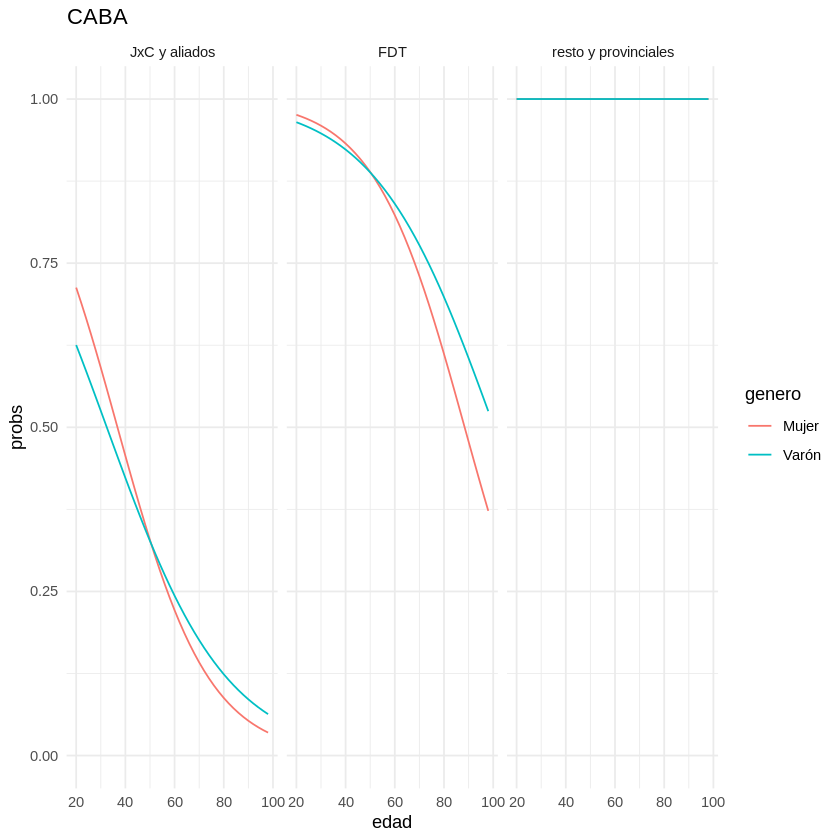

In [ ]:
expand.grid(genero=gen, edad=ed, bloque=bl, region='CABA') %>%
  mutate(probs = predict(out_bo, ., type='response')) %>%
  ggplot() + 
    geom_line(aes(x=edad, y=probs, color=genero)) +
    ylim(0,1) +
    facet_wrap(~bloque, scales = 'fixed') +
    theme_minimal() +
    labs(title = 'CABA')

---
## Actividad

Repetir este ejercicio para la región de NEA



In [ ]:
###

---